In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PDE_FIND import *
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
labelfontsize = 16; tickfontsize = 16; titlefontsize = 18

In [2]:
from scipy.interpolate import barycentric_interpolate

# Data

In [3]:
data = sio.loadmat('C:/Users/Margarita/Desktop/PDE-FIND-master/Datasets/Lorenz_system.mat')

In [4]:
Cheb_data = sio.loadmat('C:/Users/Margarita/Desktop/PDE-FIND-master/Datasets/Lorenz_system_Chebyshev.mat')

In [5]:
t = data['t'].T[0]
x = data['x'].T[0]
y = data['y'].T[0]
z = data['z'].T[0]

In [18]:
t.size

100001

In [6]:
t_c = Cheb_data['t_c'].T[0]
x_c = Cheb_data['x_c'].T[0]
y_c = Cheb_data['y_c'].T[0]
z_c = Cheb_data['z_c'].T[0]

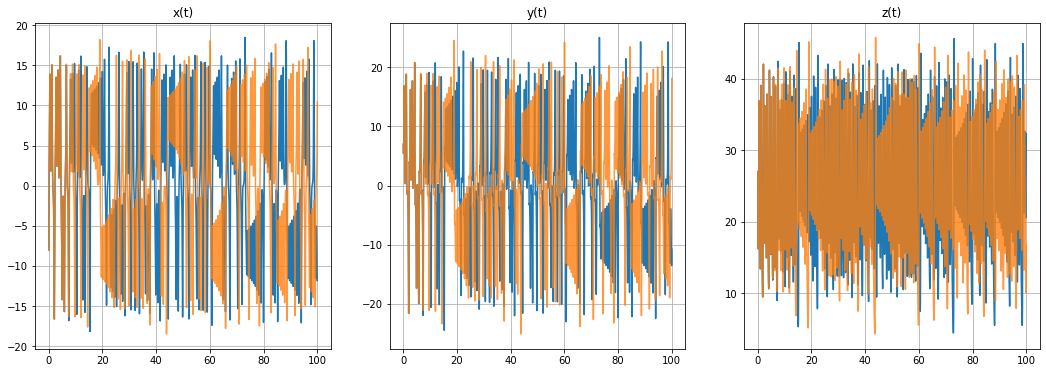

In [7]:
fig, axes = plt.subplots(1, 3)
for ax in fig.axes:
    ax.grid(True)


axes[0].plot(t, x)
axes[0].plot(t_c, x_c,alpha=0.8)
axes[0].set_title('x(t)')


axes[1].plot(t, y)
axes[1].plot(t_c, y_c,alpha=0.8)
axes[1].set_title('y(t)')

axes[2].plot(t, z)
axes[2].plot(t_c, z_c,alpha=0.8)
axes[2].set_title('z(t)')

fig.set_figwidth(18)
fig.set_figheight(6) 
plt.show()

In [19]:
dt = t[2]-t[1]
size = t.shape[0]

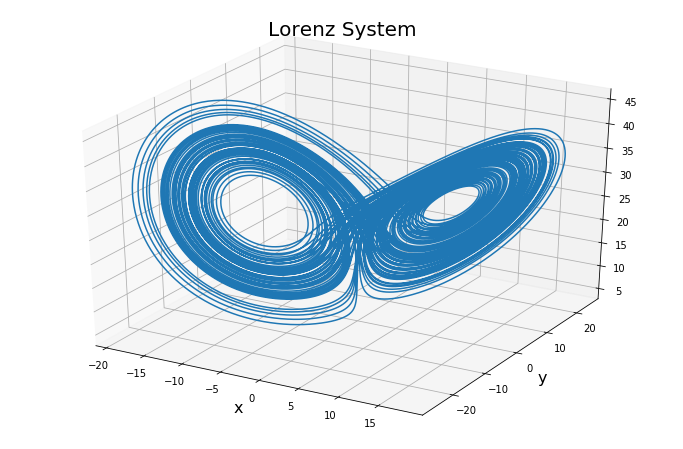

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='parametric curve')
plt.title('Lorenz System', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
fig.set_figwidth(12)
fig.set_figheight(8) 
plt.savefig('Lorenz.pdf')

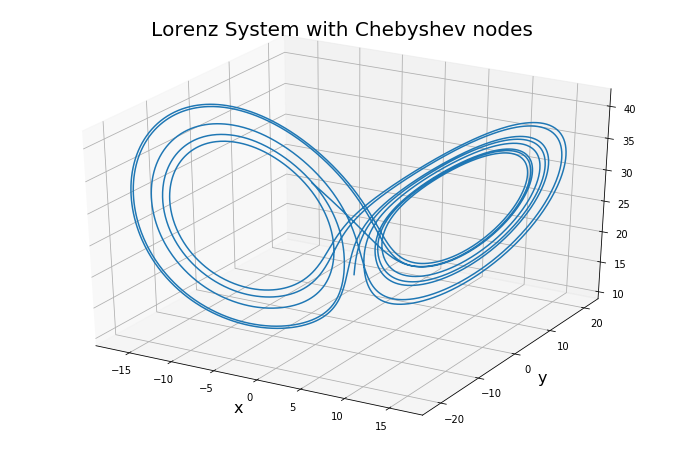

In [14]:
#plt.figure(figsize=(15,10))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_c, y_c, z_c, label='parametric curve')
plt.title('Lorenz System with Chebyshev nodes', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
fig.set_figwidth(12)
fig.set_figheight(8) 
#plt.show()
plt.savefig('Lorenz.pdf')

# Construct $\Theta (X)$ and compute $\dot X$

In [12]:
x_t = FiniteDiff(x, dt, 1).reshape(size, 1)
y_t = FiniteDiff(y, dt, 1).reshape(size, 1)
z_t = FiniteDiff(z, dt, 1).reshape(size, 1)
x = x.reshape(size,1)
y = y.reshape(size,1)
z = z.reshape(size,1)
X_data = np.hstack([x,y,z])
X_ders = np.ones((size,1))
X_ders_descr = ['']
Theta, description = build_Theta(X_data, X_ders, X_ders_descr, 5, data_description = ['x','y','z'])
['1'] + description[1:]

['1',
 'z',
 'y',
 'x',
 'z^2',
 'yz',
 'y^2',
 'xz',
 'xy',
 'x^2',
 'z^3',
 'yz^2',
 'y^2z',
 'y^3',
 'xz^2',
 'xyz',
 'xy^2',
 'x^2z',
 'x^2y',
 'x^3',
 'z^4',
 'yz^3',
 'y^2z^2',
 'y^3z',
 'y^4',
 'xz^3',
 'xyz^2',
 'xy^2z',
 'xy^3',
 'x^2z^2',
 'x^2yz',
 'x^2y^2',
 'x^3z',
 'x^3y',
 'x^4',
 'z^5',
 'yz^4',
 'y^2z^3',
 'y^3z^2',
 'y^4z',
 'y^5',
 'xz^4',
 'xyz^3',
 'xy^2z^2',
 'xy^3z',
 'xy^4',
 'x^2z^3',
 'x^2yz^2',
 'x^2y^2z',
 'x^2y^3',
 'x^3z^2',
 'x^3yz',
 'x^3y^2',
 'x^4z',
 'x^4y',
 'x^5']

In [21]:
Theta.shape

(100001, 56)

# Solve for $\xi$ (SINDy)

In [13]:
def SINdy(Theta, x, tol):
    n = x.shape[1]
##compute Sparse regression: sequential least squares 
    w = np.linalg.lstsq(Theta,x,rcond = None)[0]; ##initial guess: Least-squares
    #print(w)
## lambda is our sparsification knob. 
    for k in range(10): 
        smallinds = np.where(abs(w) < tol)[0]; ##find small coefficients 
        w[smallinds] = 0; ## and threshold 
        for ind in range(n): ## n is state dimension 
            biginds = [i for i in range(Theta.shape[1]) if i not in smallinds] 
        ## Regress dynamics onto remaining terms to find sparse Xi 
            w[biginds,ind] = np.linalg.lstsq(Theta[:, biginds],x[:, ind],rcond = None)[0]
        #print(f"{k} iteration:", w)
    return w


In [14]:
w = SINdy(Theta, x_t, 10**-3)
print_pde(w, description, ut='dx/dt')

dx/dt = (10.002057 +0.000000i)y
    + (-10.002021 +0.000000i)x
   


In [58]:
w = SINdy(Theta, y_t, 5**-3)
print_pde(w, description, ut='dy/dt')

dy/dt = (-0.981864 +0.000000i)y
    + (27.938522 +0.000000i)x
    + (-0.998078 +0.000000i)xz
   


## Correct identification!

### TrainSTRidge

In [16]:
w_x = TrainSTRidge(Theta, x_t, 10**-5, 10**-3,normalize = 0)
print_pde(w_x, description, ut='dx/dt')
w_y = TrainSTRidge(Theta, y_t, 10**-5, 10**-3,normalize = 0)
print_pde(w_y, description, ut='dy/dt')
w_z = TrainSTRidge(Theta, z_t, 10**-5, 10**-3,normalize = 0)
print_pde(w_z, description, ut='dz/dt')

Optimal tolerance: 0.006614035087719297
dx/dt = (10.002057 +0.000000i)y
    + (-10.002021 +0.000000i)x
   
Optimal tolerance: 0.01708333333333334
dy/dt = (-0.981864 +0.000000i)y
    + (27.938522 +0.000000i)x
    + (-0.998078 +0.000000i)xz
   
Optimal tolerance: 0.0030603174603174607
dz/dt = (-1.774458 +0.000000i)z
    + (-0.049389 +0.000000i)z^2
    + (1.598329 +0.000000i)x^2
    + (0.019518 +0.000000i)xyz
    + (-0.032027 +0.000000i)x^2z
   


### SINdy

In [53]:
w_x = SINdy(Theta, x_t, 2**-3)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta, y_t, 2**-3)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta, z_t, 2**-3)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (10.002057 +0.000000i)y
    + (-10.002021 +0.000000i)x
   
dy/dt = (0.545626 +0.000000i)
    + (20.794584 +0.000000i)y
    + (-7.136472 +0.000000i)x
    + (-0.622903 +0.000000i)yz
   
dz/dt = (-2.667427 +0.000000i)z
    + (0.999796 +0.000000i)xy
   


In [63]:
w_y = SINdy(Theta, y_t, 0.01)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (-0.981864 +0.000000i)y
    + (27.938522 +0.000000i)x
    + (-0.998078 +0.000000i)xz
   


In [68]:
err = abs(np.array([(10 - 10.002057)*100/10, (10 - 10.002021)*100/10, (28-27.938522)*100/28, (1-0.998078)*100, 
                    (1-0.981864)*100, (1 - 0.999796)*100, (8/3-2.667427)*100/8/3]))
print(np.mean(err))
print(np.std(err))

0.3271017630385491
0.6125570641005915


In [65]:
w_z = SINdy(Theta, z_t, 0.01)
print_pde(w_z, description, ut='dz/dt')

dz/dt = (0.020333 +0.000000i)
    + (-2.668188 +0.000000i)z
    + (0.999796 +0.000000i)xy
   


In [54]:
w_y = SINdy(Theta, y_t, 0.5)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (9.946884 +0.000000i)y
    + (-12.928457 +0.000000i)x
   


In [77]:
w_y = SINdy(Theta, y_t, 0.4)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (20.794996 +0.000000i)y
    + (-7.134796 +0.000000i)x
    + (-0.622901 +0.000000i)yz
   


In [75]:
w_y = SINdy(Theta, y_t, 0.09)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (0.545626 +0.000000i)
    + (20.794584 +0.000000i)y
    + (-7.136472 +0.000000i)x
    + (-0.622903 +0.000000i)yz
   


In [73]:
w_z = SINdy(Theta, z_t, 0.5)
print_pde(w_z, description, ut='dz/dt')

dz/dt = (-2.667427 +0.000000i)z
    + (0.999796 +0.000000i)xy
   


In [51]:
w_x = SINdy(Theta[:800,:], x_t[:800], 2**-3)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta[:800, :], y_t[:800], 2**-3)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta[:800,:], z_t[:800], 2**-3)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (10.001793 +0.000000i)y
    + (-10.001942 +0.000000i)x
   
dy/dt = (-0.990636 +0.000000i)y
    + (27.951708 +0.000000i)x
    + (-0.998196 +0.000000i)xz
   
dz/dt = (-2.667305 +0.000000i)z
    + (0.999628 +0.000000i)xy
   


In [62]:
w_y = SINdy(Theta, y_t, 0.01)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (-0.981864 +0.000000i)y
    + (27.938522 +0.000000i)x
    + (-0.998078 +0.000000i)xz
   


#### 1000 points are used

In [52]:
w_x = SINdy(Theta[:1000,:], x_t[:1000], 2**-3)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta[:1000, :], y_t[:1000], 2**-3)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta[:1000,:], z_t[:1000], 2**-3)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (10.001707 +0.000000i)y
    + (-10.001896 +0.000000i)x
   
dy/dt = (-0.990640 +0.000000i)y
    + (27.955276 +0.000000i)x
    + (-0.998306 +0.000000i)xz
   
dz/dt = (-2.667217 +0.000000i)z
    + (0.999617 +0.000000i)xy
   


In [67]:
err = abs(np.array([(10 - 10.001707)*100/10, (10 - 10.001896)*100/10, (28-27.955276)*100/28, (1-0.990640)*100,
                    (1-0.998306)*100, (1 - 0.999617)*100, (8/3-2.667217)*100/8/3]))
print(np.mean(err))
print(np.std(err))

0.19167880385487512
0.3105854481467787


In [40]:
w_x = SINdy(Theta[:1000,:], x_t[:1000], 0.5)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta[:1000, :], y_t[:1000], 0.5)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta[:1000,:], z_t[:1000], 0.5)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (10.001707 +0.000000i)y
    + (-10.001896 +0.000000i)x
   
dy/dt = (-0.990640 +0.000000i)y
    + (27.955276 +0.000000i)x
    + (-0.998306 +0.000000i)xz
   
dz/dt = (-2.667217 +0.000000i)z
    + (0.999617 +0.000000i)xy
   


In [38]:
err = abs(np.array([(10.002007 - 10)*100/10, (10.002021 - 10)*100/10, (28 - 27.943451)*100/28, (1 - 0.983396)*100,
                    (1 - 0.998201)*100, (2.667361 - 8/3)*100/8/3, (1 - 0.999789)*100]))
print ("Error using PDE-FIND to identify Lorenz system:\n")
print ("Mean parameter error:", np.mean(err), '%')
print ("Standard deviation of parameter error:", np.std(err), '%')

Error using PDE-FIND to identify Lorenz system:

Mean parameter error: 0.29835296712017934 %
Standard deviation of parameter error: 0.5616105540710984 %


Article error:  

In [43]:
err = abs(np.array([(9.9614 - 10)*100/10, (10 - 9.9796)*100/10, (28 - 27.5343)*100/28, (1 - 0.8038)*100,
                    (1 - 0.9900)*100, (2.6647 - 8/3)*100/8/3, (1 - 1.0003)*100]))
print ("Error using PDE-FIND to identify Lorenz system:\n")
print ("Mean parameter error:", np.mean(err), '%')
print ("Standard deviation of parameter error:", np.std(err), '%')

Error using PDE-FIND to identify Lorenz system:

Mean parameter error: 3.2730583900226766 %
Standard deviation of parameter error: 6.696607694920074 %


In [ ]:
w_x = SINdy(Theta, x_t, 0.1)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta, y_t, 0.1)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta, z_t, 0.1)
print_pde(w_z, description, ut='dz/dt')

In [ ]:
#w_x_true = np.zeros(Theta.shape[1], 1)
split = 0.8
N = x_t.shape[0]
train = np.random.choice(N, int(N*split), replace = False)
test = [i for i in np.arange(N) if i not in train]
w_x_tr = SINdy(Theta[train,:], x_t[train], 0.1)
print_pde(w_x_tr, description, ut='dx/dt')

subsample = 10000

In [109]:
subsample_FD = int(size*0.1)
x_t = np.zeros(subsample_FD)
y_t = np.zeros(subsample_FD)
z_t = np.zeros(subsample_FD)

x_t = FiniteDiff(x[:subsample_FD], dt, 1).reshape(subsample_FD, 1)
y_t = FiniteDiff(y[:subsample_FD], dt, 1).reshape(subsample_FD, 1)
z_t = FiniteDiff(z[:subsample_FD], dt, 1).reshape(subsample_FD, 1)
x = x.reshape(size,1)
y = y.reshape(size,1)
z = z.reshape(size,1)

X_data = np.hstack([x,y,z])
X_ders = np.ones((subsample_FD,1))
X_ders_descr = ['']

Theta, description = build_Theta(X_data[:subsample_FD,:], X_ders, X_ders_descr, 5, data_description = ['x','y','z'])

In [110]:
w_x = SINdy(Theta, x_t, 2**-3)
print_pde(w_x, description, ut='dx/dt')
w_y = SINdy(Theta, y_t, 2**-3)
print_pde(w_y, description, ut='dy/dt')
w_z = SINdy(Theta, z_t, 2**-3)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (10.002042 +0.000000i)y
    + (-10.002026 +0.000000i)x
   
dy/dt = (-0.983245 +0.000000i)y
    + (27.936150 +0.000000i)x
    + (-0.997912 +0.000000i)xz
   
dz/dt = (-2.667501 +0.000000i)z
    + (0.999907 +0.000000i)xy
   


# Identify the dynamics using the same dataset but with artificial noise

In [47]:
noise = 1

In [48]:
n = x.shape[0]
xn = np.zeros(n)
yn = np.zeros(n)
zn = np.zeros(n)

In [49]:
np.random.seed(0)
for i in range(n):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

Text(0.5, 0, 'y')

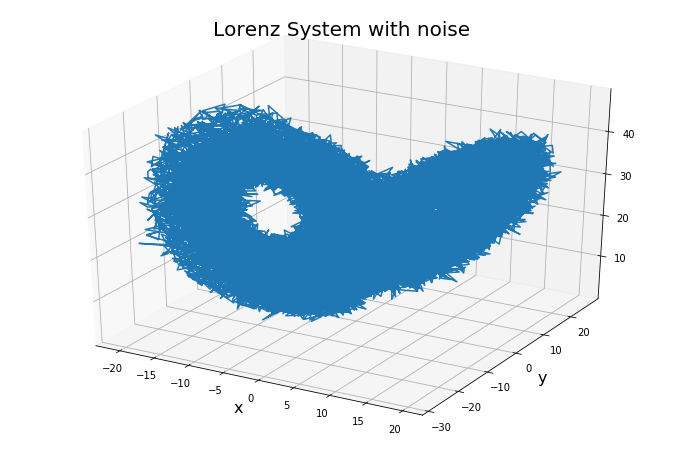

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xn, yn, zn, label='parametric curve')
plt.title('Lorenz System with noise', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
#plt.savefig('Noise_Lorenz.pdf')

In [21]:
noise = 1
np.random.seed(0)
for i in range(n):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

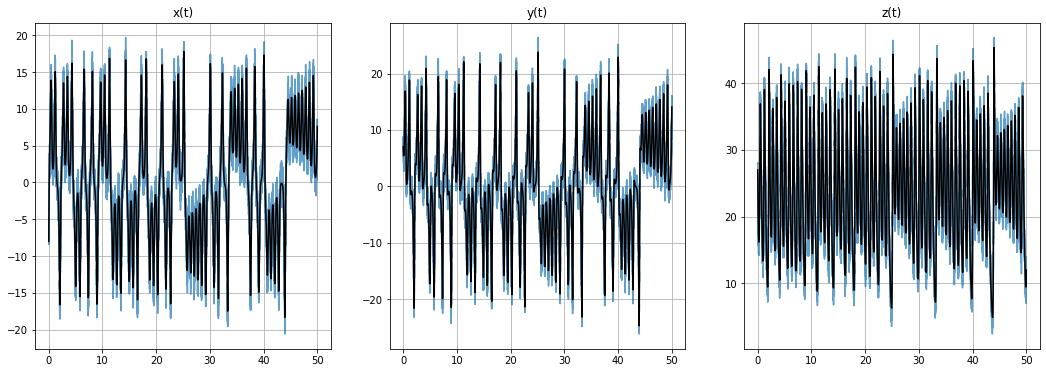

<Figure size 432x288 with 0 Axes>

In [22]:
fig, axes = plt.subplots(1, 3)
for ax in fig.axes:
    ax.grid(True)


axes[0].plot(t[:50000], xn[:50000], alpha=0.7)
axes[0].plot(t[:50000], x[:50000], color='black')
axes[0].set_title('x(t)')



axes[1].plot(t[:50000], yn[:50000], alpha=0.7)
axes[1].plot(t[:50000], y[:50000],color='black')
axes[1].set_title('y(t)')



axes[2].plot(t[:50000], zn[:50000], alpha=0.7)
axes[2].plot(t[:50000], z[:50000],color='black')
axes[2].set_title('z(t)')

fig.set_figwidth(18)
fig.set_figheight(6) 
plt.show()
plt.savefig('Lorenz_data.pdf')

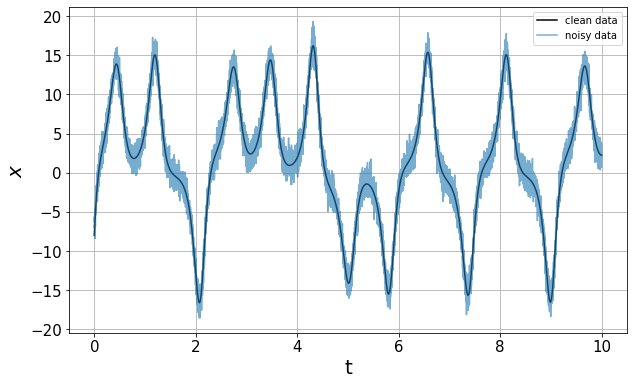

In [28]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x[:10000], color='black',label='clean data')
plt.plot(t[:10000], xn[:10000], alpha=0.6, label='noisy data')

plt.xlabel('t', fontsize=20)
plt.ylabel(r'$x$',fontsize=20)
plt.legend(loc='best')
plt.savefig('x.pdf')

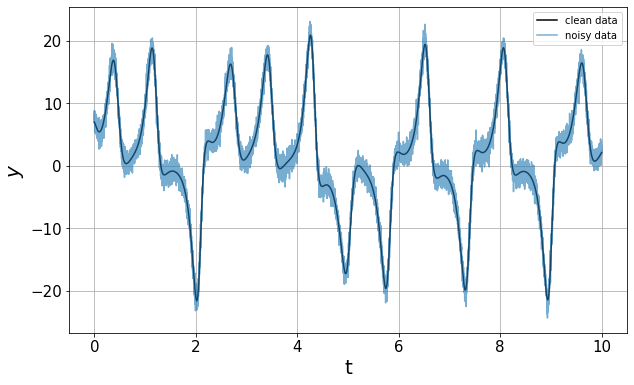

In [30]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y[:10000], color='black',label='clean data')
plt.plot(t[:10000], yn[:10000], alpha=0.6, label='noisy data')

plt.xlabel('t', fontsize=20)
plt.ylabel(r'$y$',fontsize=20)
plt.legend(loc='best')
plt.savefig('y.pdf')

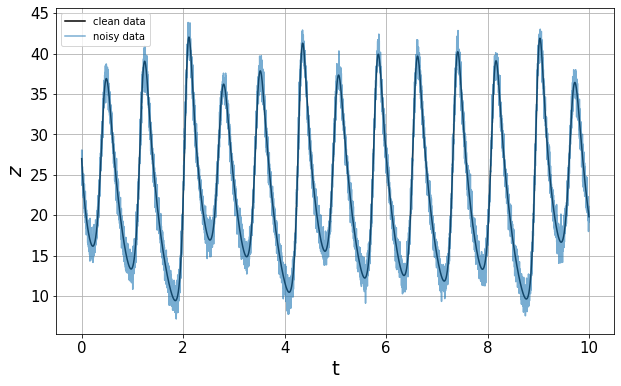

In [29]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], z[:10000], color='black',label='clean data')
plt.plot(t[:10000], zn[:10000], alpha=0.6, label='noisy data')

plt.xlabel('t', fontsize=20)
plt.ylabel(r'$z$',fontsize=20)
plt.legend(loc='best')
plt.savefig('z.pdf')

## FD (Finite differences)

In [56]:
np.random.seed(0)
noise = [0.0001, 0.001, 0.01, 0.1, 1, 10]
wx_true = np.zeros(Theta.shape[0])
wy_true = np.zeros(Theta.shape[0])
wz_true = np.zeros(Theta.shape[0])
wx_true[2] = 10; wx_true[3] = -10; wy_true[2] = -1; wy_true[3] = 28; wy_true[7] = -1; wz_true[1] = - 8/3; 
wz_true[8] = 1;
err_FD = {}
for k in range(len(noise)):
    err_FD[k] = []
    for i in range(n):
        xn[i] = x[i] + noise[k]*np.random.randn()
        yn[i] = y[i] + noise[k]*np.random.randn()
        zn[i] = z[i] + noise[k]*np.random.randn()
    xn = xn.reshape(n, 1)
    yn = yn.reshape(n, 1)
    zn = zn.reshape(n, 1)
    xn_t = FiniteDiff(xn, dt, 1).reshape(size, 1)
    yn_t = FiniteDiff(yn, dt, 1).reshape(size, 1)
    zn_t = FiniteDiff(zn, dt, 1).reshape(size, 1)
    Xn_data = np.hstack([xn,yn,zn])
    Xn_ders = np.ones((size,1))
    Xn_ders_descr = ['']
    Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    print(f"{k + 1} iteration: noise=", noise[k])
    w_xn = SINdy(Theta, xn_t, 2**-3)
    print_pde(w_xn, description, ut='dx/dt')
    w_yn = SINdy(Theta, yn_t, 2**-3)
    print_pde(w_yn, description, ut='dy/dt')
    w_zn = SINdy(Theta, zn_t, 2**-3)
    print_pde(w_zn, description, ut='dz/dt')
    err_FD[k].append(np.linalg.norm(w_xn - wx_true, 1))
    err_FD[k].append(np.linalg.norm(w_yn - wy_true, 1))
    err_FD[k].append(np.linalg.norm(w_zn - wz_true, 1))

1 iteration: noise= 0.0001
dx/dt = (10.002020 +0.000000i)y
    + (-10.002007 +0.000000i)x
   
dy/dt = (-0.983395 +0.000000i)y
    + (27.943451 +0.000000i)x
    + (-0.998202 +0.000000i)xz
   
dz/dt = (-2.667361 +0.000000i)z
    + (0.999789 +0.000000i)xy
   
2 iteration: noise= 0.001
dx/dt = (10.002032 +0.000000i)y
    + (-10.002025 +0.000000i)x
   
dy/dt = (-0.983326 +0.000000i)y
    + (27.943293 +0.000000i)x
    + (-0.998199 +0.000000i)xz
   
dz/dt = (-2.667362 +0.000000i)z
    + (0.999788 +0.000000i)xy
   
3 iteration: noise= 0.01
dx/dt = (10.001574 +0.000000i)y
    + (-10.001377 +0.000000i)x
   
dy/dt = (-0.984377 +0.000000i)y
    + (27.946009 +0.000000i)x
    + (-0.998253 +0.000000i)xz
   
dz/dt = (-2.667319 +0.000000i)z
    + (0.999771 +0.000000i)xy
   
4 iteration: noise= 0.1
dx/dt = (9.990579 +0.000000i)y
    + (-9.989387 +0.000000i)x
   
dy/dt = (-0.964155 +0.000000i)y
    + (27.883343 +0.000000i)x
    + (-0.996859 +0.000000i)xz
   
dz/dt = (-2.666003 +0.000000i)z
    + (0.99936

Noise = 1

In [58]:
np.random.seed(0)
noise = 1
for i in range(n):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

In [59]:
xn = xn.reshape(n, 1)
yn = yn.reshape(n, 1)
zn = zn.reshape(n, 1)
xn_t = FiniteDiff(xn, dt, 1).reshape(size, 1)
yn_t = FiniteDiff(yn, dt, 1).reshape(size, 1)
zn_t = FiniteDiff(zn, dt, 1).reshape(size, 1)
Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size,1))
Xn_ders_descr = ['']
Theta_n, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
w_xn = SINdy(Theta_n, xn_t, 0.5)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_n, yn_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_n, zn_t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.108157 +0.000000i)y
    + (-8.966052 +0.000000i)x
   
dy/dt = (24.532030 +0.000000i)x
    + (-0.919474 +0.000000i)xz
   
dz/dt = (-0.708034 +0.000000i)
    + (-2.574447 +0.000000i)z
    + (0.976484 +0.000000i)xy
   


In [76]:
w_zn = SINdy(Theta_n, zn_t, 0.7)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.600904 +0.000000i)z
    + (0.976480 +0.000000i)xy
   


In [73]:
w_yn = SINdy(Theta_n, yn_t, 0.2)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.251116 +0.000000i)y
    + (23.945509 +0.000000i)x
    + (-0.908097 +0.000000i)xz
   


In [77]:
w_xn = SINdy(Theta_n, xn_t, 0.7)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_n, yn_t, 0.7)
print_pde(w_yn, description, ut='dy/dt')

dx/dt = (9.108157 +0.000000i)y
    + (-8.966052 +0.000000i)x
   
dy/dt = (2.781737 +0.000000i)
    + (8.930303 +0.000000i)y
    + (-11.733143 +0.000000i)x
   


In [207]:
err = abs(np.array([(10 - 9.108157)*100/10, (10 - 8.966052)*100/10, (28-23.945509)*100/28, (1+0.251116)*100,
                    (1-0.908097)*100, (1 - 0.976480)*100, (8/3-2.600904)*100/8/3]))
print(np.mean(err))
print(np.std(err))

24.38087801587302
41.36615873151417


In [52]:
np.random.seed(0)
noise = [0.0001, 0.001, 0.01, 0.1, 1, 10]
for k in range(len(noise)):
    #err_FD[k] = []
    for i in range(n):
        xn[i] = x[i] + noise[k]*np.random.randn()
        yn[i] = y[i] + noise[k]*np.random.randn()
        zn[i] = z[i] + noise[k]*np.random.randn()
    xn = xn.reshape(n, 1)
    yn = yn.reshape(n, 1)
    zn = zn.reshape(n, 1)
    xn_t = FiniteDiff(xn, dt, 1).reshape(size, 1)
    yn_t = FiniteDiff(yn, dt, 1).reshape(size, 1)
    zn_t = FiniteDiff(zn, dt, 1).reshape(size, 1)
    Xn_data = np.hstack([xn,yn,zn])
    Xn_ders = np.ones((size,1))
    Xn_ders_descr = ['']
    Theta_n, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    w_xn = SINdy(Theta_n, xn_t, 0.5)
    print_pde(w_xn, description, ut='dx/dt')
    w_yn = SINdy(Theta_n, yn_t, 0.5)
    print_pde(w_yn, description, ut='dy/dt')
    w_zn = SINdy(Theta_n, zn_t, 0.5)
    print_pde(w_zn, description, ut='dz/dt')

dx/dt = (10.002022 +0.000000i)y
    + (-10.002007 +0.000000i)x
   
dy/dt = (-2.903101 +0.000000i)x
   
dz/dt = 
dx/dt = (10.002012 +0.000000i)y
    + (-10.002002 +0.000000i)x
   
dy/dt = (-2.903102 +0.000000i)x
   
dz/dt = 
dx/dt = (-2.411255 +0.000000i)
    + (2.288735 +0.000000i)y
   
dy/dt = (-0.984427 +0.000000i)y
    + (27.946449 +0.000000i)x
    + (-0.998265 +0.000000i)xz
   
dz/dt = 
dx/dt = (10.000704 +0.000000i)y
    + (-10.000922 +0.000000i)x
   
dy/dt = (-0.981493 +0.000000i)y
    + (27.939337 +0.000000i)x
    + (-0.998138 +0.000000i)xz
   
dz/dt = (-2.666995 +0.000000i)z
    + (0.999703 +0.000000i)xy
   
dx/dt = (9.983223 +0.000000i)y
    + (-9.979459 +0.000000i)x
   
dy/dt = (-1.020891 +0.000000i)y
    + (28.023386 +0.000000i)x
    + (-0.999558 +0.000000i)xz
   
dz/dt = (87.864182 +0.000000i)
    + (-7.376094 +0.000000i)z
    + (1.368145 +0.000000i)x^2
   
dx/dt = (10.118019 +0.000000i)y
    + (-10.133474 +0.000000i)x
   
dy/dt = (-0.947731 +0.000000i)y
    + (27.911289 +0

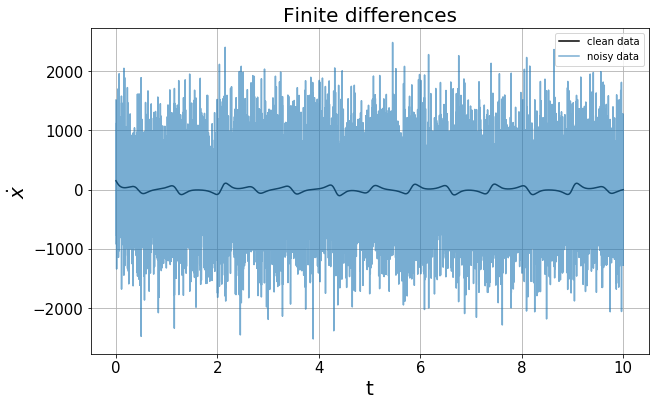

In [60]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, color='black',label='clean data')
plt.plot(t[:10000], xn_t[:10000].real, alpha=0.6, label='noisy data')
plt.title('Finite differences', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_x.pdf')

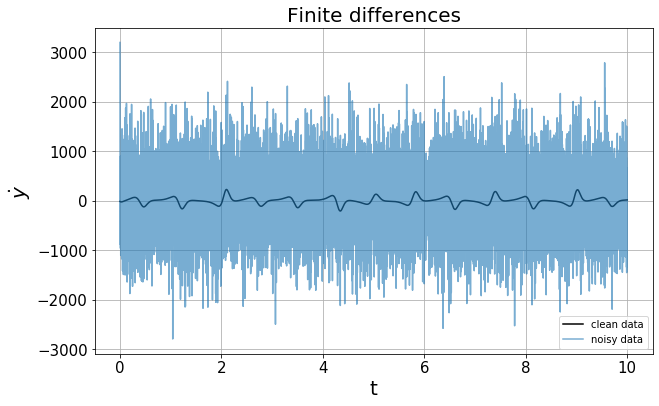

In [81]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y_t[:10000].real, color='black',label='clean data')
plt.plot(t[:10000], yn_t[:10000].real, alpha=0.6, label='noisy data')
plt.title('Finite differences', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot y$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_y.pdf')

## PolyDiffPoint (Derivatives of the Polynomial interpolation)

In [84]:
boundary = 5 # as well as Navier-Stokes
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
noise = [0.0001, 0.001, 0.01, 0.1, 1, 10]
#noise = 0.1
numpy.random.seed(0)
err_PDP = {}
for k in range(len(noise)):
    err_PDP[k] = []
    xn = np.zeros(size)
    yn = np.zeros(size)
    zn = np.zeros(size)
    xn_t = np.zeros(size-10)
    yn_t = np.zeros(size-10)
    zn_t = np.zeros(size-10)
    for i in range(size):
        xn[i] = x[i] + noise[k]*np.random.randn()
        yn[i] = y[i] + noise[k]*np.random.randn()
        zn[i] = z[i] + noise[k]*np.random.randn()
    for p in range(size - 10):
        j = p + 5
        xn_t[p] = PolyDiffPoint(xn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
        yn_t[p] = PolyDiffPoint(yn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
        zn_t[p] = PolyDiffPoint(zn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

    xn = xn.reshape(size,1)
    yn = yn.reshape(size,1)
    zn = zn.reshape(size,1)
    xn_t = xn_t.reshape(size-10,1)
    yn_t = yn_t.reshape(size-10,1)
    zn_t = zn_t.reshape(size-10,1)

    Xn_data = np.hstack([xn,yn,zn])
    Xn_ders = np.ones((size - 10,1))
    Xn_ders_descr = ['']
    Theta, description = build_Theta(Xn_data[5:size-5, :], Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])

    print(f"{k + 1} iteration: noise=", noise[k])
    w_xn = SINdy(Theta, xn_t, 2**-3)
    print_pde(w_xn, description, ut='dx/dt')
    w_yn = SINdy(Theta, yn_t, 2**-3)
    print_pde(w_yn, description, ut='dy/dt')
    w_zn = SINdy(Theta, zn_t, 2**-3)
    print_pde(w_zn, description, ut='dz/dt')
    err_PDP[k].append(np.linalg.norm(w_xn - wx_true, 1))
    err_PDP[k].append(np.linalg.norm(w_yn - wy_true, 1))
    err_PDP[k].append(np.linalg.norm(w_zn - wz_true, 1))

1 iteration: noise= 0.0001
dx/dt = (10.002242 +0.000000i)y
    + (-10.002229 +0.000000i)x
   
dy/dt = (-0.983767 +0.000000i)y
    + (27.945396 +0.000000i)x
    + (-0.998256 +0.000000i)xz
   
dz/dt = (-2.667439 +0.000000i)z
    + (0.999819 +0.000000i)xy
   
2 iteration: noise= 0.001
dx/dt = (10.002262 +0.000000i)y
    + (-10.002256 +0.000000i)x
   
dy/dt = (-0.983725 +0.000000i)y
    + (27.945303 +0.000000i)x
    + (-0.998255 +0.000000i)xz
   
dz/dt = (-2.667440 +0.000000i)z
    + (0.999817 +0.000000i)xy
   
3 iteration: noise= 0.01
dx/dt = (10.002152 +0.000000i)y
    + (-10.002009 +0.000000i)x
   
dy/dt = (20.793131 +0.000000i)y
    + (-7.045650 +0.000000i)x
    + (-0.622962 +0.000000i)yz
   
dz/dt = (-2.667408 +0.000000i)z
    + (0.999803 +0.000000i)xy
   
4 iteration: noise= 0.1
dx/dt = (9.990827 +0.000000i)y
    + (-9.989732 +0.000000i)x
   
dy/dt = (-0.967813 +0.000000i)y
    + (27.893616 +0.000000i)x
    + (-0.997071 +0.000000i)xz
   
dz/dt = (-2.666365 +0.000000i)z
    + (0.99944

Noise = 1

In [86]:
boundary = 10 # number of points to use in fitting
Nt = 2*boundary-1 
deg = 10 # degree of polynomial to use

numpy.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
xn_t = np.zeros(size-2*boundary)
yn_t = np.zeros(size-2*boundary)
zn_t = np.zeros(size-2*boundary)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()
       
for p in range(size - 2*boundary):
    j = p + 10
    xn_t[p] = PolyDiffPoint(xn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    yn_t[p] = PolyDiffPoint(yn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    zn_t[p] = PolyDiffPoint(zn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

In [87]:
xn = xn.reshape(size,1)
yn = yn.reshape(size,1)
zn = zn.reshape(size,1)
xn_t = xn_t.reshape(size-2*boundary,1)
yn_t = yn_t.reshape(size-2*boundary,1)
zn_t = zn_t.reshape(size-2*boundary,1)

Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size - 2*boundary,1))
Xn_ders_descr = ['']
Theta_n, description = build_Theta(Xn_data[boundary:size-boundary, :], Xn_ders, Xn_ders_descr, 5,
                                   data_description = ['x','y','z'])

In [88]:
w = np.linalg.lstsq(Theta_n, xn_t,rcond = None)[0]; ##initial guess: Least-squares
print(w)

[[ 6.13813171e+01+0.j]
 [-1.74484250e+01+0.j]
 [ 8.12216812e+00+0.j]
 [-4.79324539e+00+0.j]
 [ 1.74776890e+00+0.j]
 [-8.52022910e-01+0.j]
 [-3.93375111e-01+0.j]
 [ 1.58074829e+00+0.j]
 [ 1.27517918e+00+0.j]
 [-9.45577519e-02+0.j]
 [-7.92681870e-02+0.j]
 [ 2.94959935e-02+0.j]
 [ 8.66568162e-02+0.j]
 [ 4.41986685e-02+0.j]
 [-8.92404196e-02+0.j]
 [-2.95991560e-01+0.j]
 [-2.56061046e-01+0.j]
 [ 1.11909437e-01+0.j]
 [ 4.74975136e-01+0.j]
 [-3.03847644e-01+0.j]
 [ 1.63282629e-03+0.j]
 [ 7.02687792e-04+0.j]
 [-2.85909372e-03+0.j]
 [-3.83707506e-03+0.j]
 [-3.40982980e-03+0.j]
 [ 4.25616437e-04+0.j]
 [ 1.22384579e-02+0.j]
 [ 2.31160640e-02+0.j]
 [ 1.02313150e-02+0.j]
 [-5.44207806e-03+0.j]
 [-4.29400228e-02+0.j]
 [-8.02092089e-03+0.j]
 [ 2.75731759e-02+0.j]
 [-1.83556190e-03+0.j]
 [ 3.26286186e-03+0.j]
 [-1.24277760e-05+0.j]
 [-2.22118526e-05+0.j]
 [ 1.72067065e-05+0.j]
 [ 4.03583158e-05+0.j]
 [ 1.71266413e-04+0.j]
 [ 5.63524621e-05+0.j]
 [ 1.51174714e-05+0.j]
 [-1.37766628e-04+0.j]
 [-3.667411

Probably, noise is too large for this method...

In [92]:
w_xn = SINdy(Theta_n, xn_t, 0.7)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_n, yn_t, 0.7)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_n, zn_t, 0.7)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (-2.400401 +0.000000i)
    + (2.253205 +0.000000i)y
   
dy/dt = (24.511544 +0.000000i)x
    + (-0.917218 +0.000000i)xz
   
dz/dt = (-0.819068 +0.000000i)
    + (-2.570304 +0.000000i)z
    + (0.976834 +0.000000i)xy
   


In [104]:
w_x = TrainSTRidge(Theta_n, xn_t, 10**-5, 10**-2,normalize = 0)
print_pde(w_x, description, ut='dx/dt')
w_y = TrainSTRidge(Theta_n, yn_t, 10**-5, 10**-2,normalize = 0)
print_pde(w_y, description, ut='dy/dt')
w_z = TrainSTRidge(Theta_n, zn_t, 10**-5, 10**-2,normalize = 0)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (-0.032958 +0.000000i)xz
   
dy/dt = (20.153194 +0.000000i)y
    + (-6.237356 +0.000000i)x
    + (-0.625241 +0.000000i)yz
   
dz/dt = (-2.586352 +0.000000i)z
    + (0.041331 +0.000000i)y^2
    + (0.921568 +0.000000i)xy
   


If tol is less than $10^{-2}$, then there are many terms. Otherwise, there is only one term. 

In [105]:
boundary = 5 # number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use

np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
xn_t = np.zeros(size-2*boundary)
yn_t = np.zeros(size-2*boundary)
zn_t = np.zeros(size-2*boundary)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()
       
for p in range(size - 2*boundary):
    j = p + 5
    xn_t[p] = PolyDiffPoint(xn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    yn_t[p] = PolyDiffPoint(yn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    zn_t[p] = PolyDiffPoint(zn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

In [106]:
xn = xn.reshape(size,1)
yn = yn.reshape(size,1)
zn = zn.reshape(size,1)
xn_t = xn_t.reshape(size-2*boundary,1)
yn_t = yn_t.reshape(size-2*boundary,1)
zn_t = zn_t.reshape(size-2*boundary,1)

Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size - 2*boundary,1))
Xn_ders_descr = ['']
Theta_pn, description = build_Theta(Xn_data[boundary:size-boundary, :], Xn_ders, Xn_ders_descr, 5,
                                   data_description = ['x','y','z'])

In [107]:
w_xn = SINdy(Theta_pn, xn_t, 0.5)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_pn, yn_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_pn, zn_t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (-2.404603 +0.000000i)
    + (2.255792 +0.000000i)y
   
dy/dt = (24.438417 +0.000000i)x
    + (-0.914851 +0.000000i)xz
   
dz/dt = (-0.802334 +0.000000i)
    + (-2.566609 +0.000000i)z
    + (0.975352 +0.000000i)xy
   


In [111]:
w_zn = SINdy(Theta_pn, zn_t, 0.9)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.596589 +0.000000i)z
    + (0.975347 +0.000000i)xy
   


In [126]:
w_yn = SINdy(Theta_pn, yn_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (24.438417 +0.000000i)x
    + (-0.914851 +0.000000i)xz
   


In [123]:
w_xn = SINdy(Theta_pn, xn_t, 0.25)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.985033 +0.000000i)y
    + (-8.845653 +0.000000i)x
   


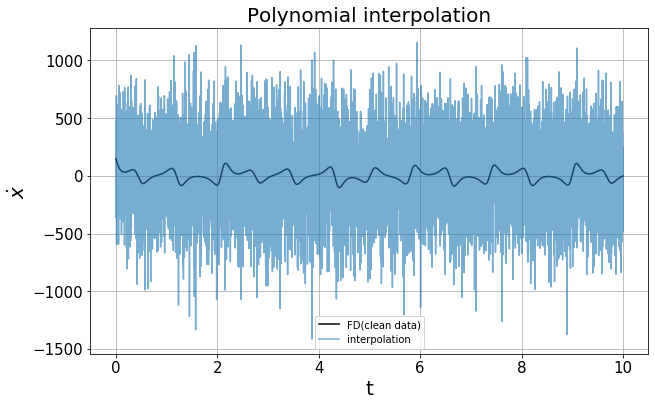

In [127]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, color='black',label='FD(clean data)')
plt.plot(t[:10000], xn_t[:10000].real, alpha=0.6, label='interpolation')
plt.title('Polynomial interpolation', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_x_p.pdf')

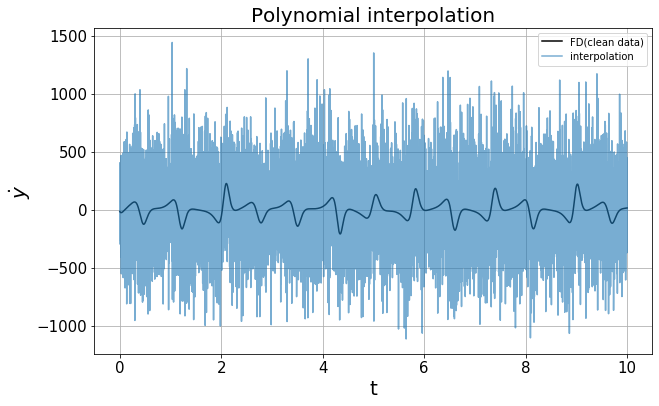

In [128]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y_t[:10000].real, color='black',label='FD(clean data)')
plt.plot(t[:10000], yn_t[:10000].real, alpha=0.6, label='interpolation')
plt.title('Polynomial interpolation', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot y$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_y_p.pdf')

boundary = 10

In [129]:
boundary = 10 # number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use

np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
xn_10t = np.zeros(size-2*boundary)
yn_10t = np.zeros(size-2*boundary)
zn_10t = np.zeros(size-2*boundary)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()
       
for p in range(size - 2*boundary):
    j = p + 10
    #print(xn[j-((Nt-1)//2):j+((Nt+1)//2)].shape)
    #print(np.arange(Nt)*dt)
    xn_10t[p] = PolyDiffPoint(xn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    yn_10t[p] = PolyDiffPoint(yn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]
    zn_10t[p] = PolyDiffPoint(zn[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

In [135]:
xn = xn.reshape(size,1)
yn = yn.reshape(size,1)
zn = zn.reshape(size,1)
xn_10t = xn_10t.reshape(size-2*boundary,1)
yn_10t = yn_10t.reshape(size-2*boundary,1)
zn_10t = zn_10t.reshape(size-2*boundary,1)

Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size - 2*boundary,1))
Xn_ders_descr = ['']
Theta_10pn, description = build_Theta(Xn_data[boundary:size-boundary, :], Xn_ders, Xn_ders_descr, 5,
                                   data_description = ['x','y','z'])

In [136]:
w_xn = SINdy(Theta_10pn, xn_10t, 0.5)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_10pn, yn_10t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_10pn, zn_10t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (2.230752 -0.000000i)y
   
dy/dt = (24.479672 +0.000000i)x
    + (-0.916564 +0.000000i)xz
   
dz/dt = (-0.789714 +0.000000i)
    + (-2.565855 +0.000000i)z
    + (0.974932 +0.000000i)xy
   


In [137]:
w_zn = SINdy(Theta_10pn, zn_10t, 0.8)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.595363 +0.000000i)z
    + (0.974926 +0.000000i)xy
   


In [169]:
w_yn = SINdy(Theta_10pn, yn_10t, 0.12)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.661387 +0.000000i)
    + (3.785296 +0.000000i)y
    + (19.656505 +0.000000i)x
    + (-0.127147 +0.000000i)yz
    + (-0.768019 +0.000000i)xz
   


In [170]:
w_yn = SINdy(Theta_10pn, yn_10t, 0.13)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.298321 +0.000000i)
    + (24.468458 +0.000000i)x
    + (-0.916357 +0.000000i)xz
   


In [162]:
w_xn = SINdy(Theta_10pn, xn_10t, 0.22)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (9.015323 +0.000000i)y
    + (-8.875487 +0.000000i)x
   


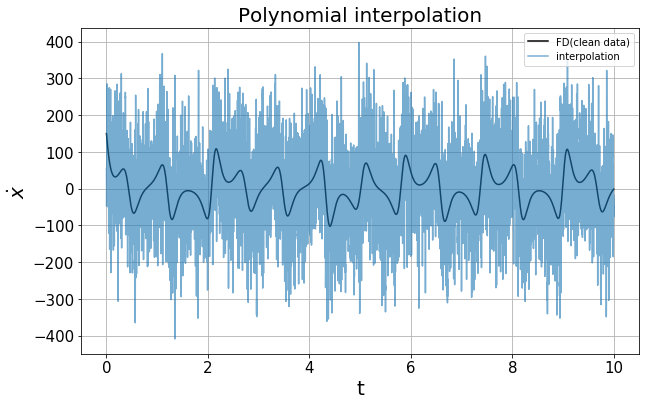

In [141]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], x_t[:10000].real, color='black',label='FD(clean data)')
plt.plot(t[:10000], xn_10t[:10000].real, alpha=0.6, label='interpolation')
plt.title('Polynomial interpolation', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_x_p.pdf')

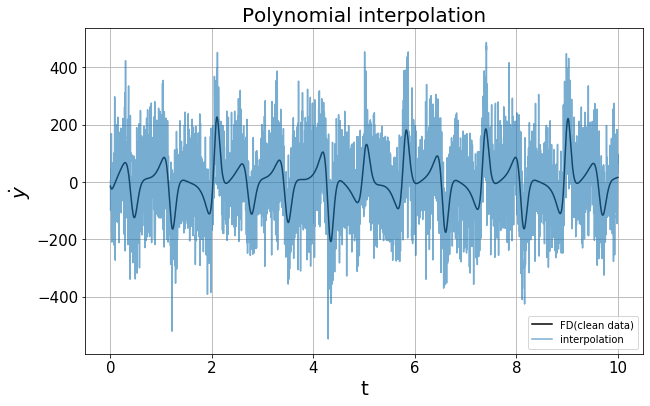

In [142]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[:10000], y_t[:10000].real, color='black',label='FD(clean data)')
plt.plot(t[:10000], yn_10t[:10000].real, alpha=0.6, label='interpolation')
plt.title('Polynomial interpolation', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot y$',fontsize=20)
plt.legend(loc='best')
plt.savefig('dot_y_p.pdf')

### Chebyshev interpolation (Poly) with FD derivatives

In [172]:
boundary = 5
width = boundary # number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use

np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)

xn_t = np.zeros(size-2*boundary)
yn_t = np.zeros(size-2*boundary)
zn_t = np.zeros(size-2*boundary)

inter_x = np.zeros(size-2*boundary)
inter_y = np.zeros(size-2*boundary)
inter_z = np.zeros(size-2*boundary)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

for j in range(width, size-width):

    points = np.arange(j - width+1, j + width)

    # Fit to a Chebyshev polynomial
    # this is the same as any polynomial since we're on a fixed grid but it's better conditioned :)
    inter_x[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],xn[points],deg)(t[j])
    inter_y[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],yn[points],deg)(t[j])
    inter_z[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],zn[points],deg)(t[j])

xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

In [174]:
xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)

Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size,1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta[:99991,:], xn_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta[:99991,:], yn_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta[:99991,:], zn_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.901478 +0.000000i)y
    + (-10.163201 +0.000000i)x
   
dy/dt = (0.286095 +0.000000i)
    + (-2.170212 +0.000000i)y
    + (28.859291 +0.000000i)x
    + (-0.997226 +0.000000i)xz
   
dz/dt = (7.438194 +0.000000i)
    + (-2.928849 +0.000000i)z
    + (0.125448 +0.000000i)y^2
    + (0.815828 +0.000000i)xy
   


In [175]:
w_yn = SINdy(Theta[:99991,:], yn_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta[:99991,:], zn_t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dy/dt = (-2.172743 +0.000000i)y
    + (28.875950 +0.000000i)x
    + (-0.997538 +0.000000i)xz
   
dz/dt = (14.294560 +0.000000i)
    + (-3.229079 +0.000000i)z
    + (0.983477 +0.000000i)xy
   


In [188]:
w_zn = SINdy(Theta[:99991,:], zn_t, 0.28)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (14.294560 +0.000000i)
    + (-3.229079 +0.000000i)z
    + (0.983477 +0.000000i)xy
   


$\xi=0.8$ is much for z 

In [129]:
w_yn = SINdy(Theta[:99991,:], yn_t, 0.8)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta[:99991,:], zn_t, 0.45)
print_pde(w_zn, description, ut='dz/dt')

dy/dt = (-2.172743 +0.000000i)y
    + (28.875950 +0.000000i)x
    + (-0.997538 +0.000000i)xz
   
dz/dt = (14.652835 +0.000000i)
    + (-0.629228 +0.000000i)z
   


boundary = 10

In [194]:
boundary = 10
width = boundary # number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use

np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)

xn_t = np.zeros(size-2*boundary)
yn_t = np.zeros(size-2*boundary)
zn_t = np.zeros(size-2*boundary)

inter_x = np.zeros(size-2*boundary)
inter_y = np.zeros(size-2*boundary)
inter_z = np.zeros(size-2*boundary)
noise = 1
for i in range(size):
    xn[i] = x[i] + noise*np.random.randn()
    yn[i] = y[i] + noise*np.random.randn()
    zn[i] = z[i] + noise*np.random.randn()

for j in range(width, size-width):

    points = np.arange(j - width+1, j + width)

    # Fit to a Chebyshev polynomial
    # this is the same as any polynomial since we're on a fixed grid but it's better conditioned :)
    inter_x[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],xn[points],deg)(t[j])
    inter_y[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],yn[points],deg)(t[j])
    inter_z[j - width] = np.polynomial.chebyshev.Chebyshev.fit(t[points],zn[points],deg)(t[j])

xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

In [190]:
xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)

Xn_data = np.hstack([xn,yn,zn])
Xn_ders = np.ones((size,1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta[width:size - width,:], xn_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta[width:size - width,:], yn_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta[width:size - width,:], zn_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (-0.871506 +0.000000i)
    + (4.131628 +0.000000i)y
    + (0.133986 +0.000000i)yz
    + (-0.254046 +0.000000i)xz
   
dy/dt = (0.285362 +0.000000i)
    + (24.532045 +0.000000i)x
    + (-0.918306 +0.000000i)xz
   
dz/dt = (-0.773446 +0.000000i)
    + (-2.566179 +0.000000i)z
    + (0.974851 +0.000000i)xy
   


In [192]:
w_xn = SINdy(Theta[width:size - width,:], xn_t, 0.3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta[width:size - width,:], yn_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta[width:size - width,:], zn_t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (8.997498 +0.000000i)y
    + (-8.857658 +0.000000i)x
   
dy/dt = (24.542772 +0.000000i)x
    + (-0.918503 +0.000000i)xz
   
dz/dt = (-0.773446 +0.000000i)
    + (-2.566179 +0.000000i)z
    + (0.974851 +0.000000i)xy
   


### Instead of initial noise data using interpolation data

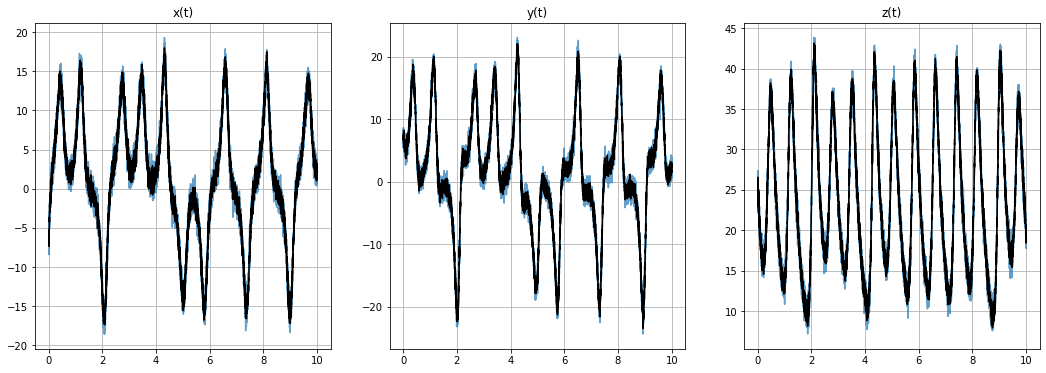

In [116]:
fig, axes = plt.subplots(1, 3)
for ax in fig.axes:
    ax.grid(True)


axes[0].plot(t[5:10005], xn[5:10005], alpha=0.7)
axes[0].plot(t[5:10005], inter_x[:10000], color='black')
axes[0].set_title('x(t)')



axes[1].plot(t[5:10005], yn[5:10005], alpha=0.7)
axes[1].plot(t[5:10005], inter_y[:10000],color='black')
axes[1].set_title('y(t)')



axes[2].plot(t[5:10005], zn[5:10005], alpha=0.7)
axes[2].plot(t[5:10005], inter_z[:10000],color='black')
axes[2].set_title('z(t)')

fig.set_figwidth(18)
fig.set_figheight(6) 
plt.show()

In [196]:
x_n = inter_x.reshape(size - 2*width, 1)
y_n = inter_y.reshape(size - 2*width, 1)
z_n = inter_z.reshape(size - 2*width, 1)

Xn_data = np.hstack([x_n,y_n,z_n])
Xn_ders = np.ones((size - 2*width,1))
Xn_ders_descr = ['']

Theta_s, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta_s, xn_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_s, yn_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_s, zn_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.785979 +0.000000i)y
    + (-9.757232 +0.000000i)x
   
dy/dt = (-0.757871 +0.000000i)y
    + (27.213242 +0.000000i)x
    + (-0.981446 +0.000000i)xz
   
dz/dt = (-2.649940 +0.000000i)z
    + (0.994246 +0.000000i)xy
   


In [205]:
err = abs(np.array([(10 - 9.757232)*100/10, (10 - 9.785979)*100/10, (28-27.213242)*100/28, (1-0.757871)*100,
                    (1-0.981446)*100, (1 - 0.994246)*100, (8/3-2.649940)*100/8/3]))
print(np.mean(err))
print(np.std(err))

4.870162063492065
7.9496901504923505


In [195]:
x_t = FiniteDiff(x, dt, 1).reshape(size, 1)
y_t = FiniteDiff(y, dt, 1).reshape(size, 1)
z_t = FiniteDiff(z, dt, 1).reshape(size, 1)

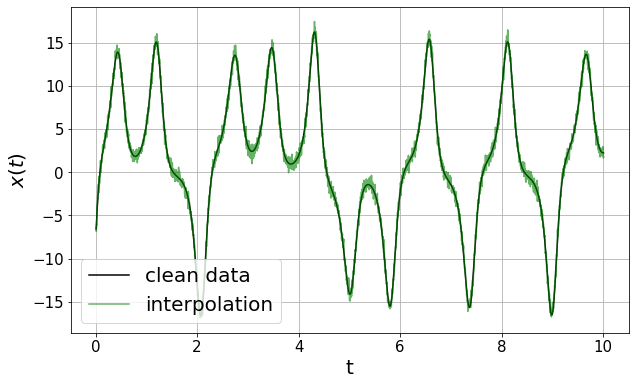

In [203]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(t[width:10000+width], x[width:10000+width].real, color='black',label='clean data')
plt.plot(t[width:10000+width], inter_x[:10000].real,'g-', alpha=0.6, label='interpolation')
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$x(t)$',fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.savefig('x(poly).pdf')

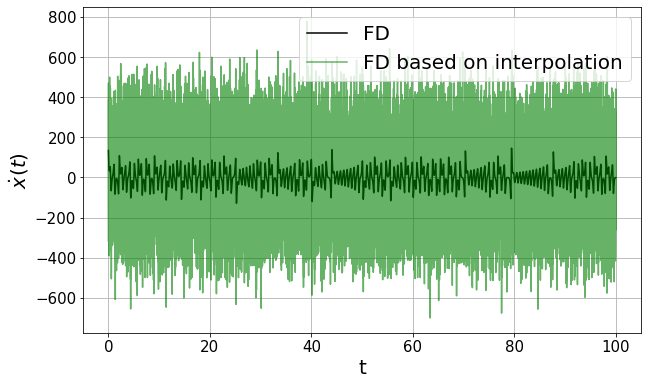

In [208]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(t[width:size - width], x_t[width:size - width].real, color='black',label='FD')
plt.plot(t[width:size - width], xn_t.real,'g-', alpha=0.6, label='FD based on interpolation')
#plt.title('u(x, 10)', fontsize = 20)
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x(t)$',fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.savefig('dot_x(poly_and_FD).pdf')

## Wow! It's the first time when the equation for z is correct witn noise=1!

In [197]:
w_zn = SINdy(Theta_s, zn_t, 0.4)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.649940 +0.000000i)z
    + (0.994246 +0.000000i)xy
   


And other equations is correct! The threshold is optimal from 0.3 to 0.4 

In [85]:
w_xn = SINdy(Theta, xn_t, 0.4)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yn_t, 0.4)
print_pde(w_yn, description, ut='dy/dt')

dx/dt = (9.533098 +0.000000i)y
    + (-9.471333 +0.000000i)x
   
dy/dt = (-0.537514 +0.000000i)y
    + (26.427378 +0.000000i)x
    + (-0.962691 +0.000000i)xz
   


In [96]:
w_z = TrainSTRidge(Theta, zn_t, 10**-5, 10**-3,normalize = 0)
print_pde(w_z, description, ut='dz/dt')

dz/dt = (-2.639681 +0.000000i)z
    + (0.990505 +0.000000i)xy
   


At the moment TrainSTRidge doesn't work:( (for x)

In [110]:
w_y = TrainSTRidge(Theta, yn_t, 0, 0.4,normalize = 0)
print_pde(w_y, description, ut='dy/dt')

dy/dt = (-0.537514 +0.000000i)y
    + (26.427378 +0.000000i)x
    + (-0.962691 +0.000000i)xz
   


In [112]:
w_x = TrainSTRidge(Theta, xn_t, 0, 0.5,normalize = 0)
print_pde(w_x, description, ut='dx/dt')

dx/dt = (0.065649 -0.000000i)
   


In [106]:
maxit = 25
tol = 2**-3
d_tol = 10
for itrs in range(maxit):
# Get a set of coefficients and error

    tol = max([0,tol - 2*d_tol])
    d_tol  = 2*d_tol / (maxit - itrs)
    tol = tol + d_tol
    print(f'Otherwise:', tol, d_tol)

Otherwise: 0.8 0.8
Otherwise: 0.06666666666666667 0.06666666666666667
Otherwise: 0.005797101449275362 0.005797101449275362
Otherwise: 0.0005270092226613965 0.0005270092226613965
Otherwise: 5.019135453918062e-05 5.019135453918062e-05
Otherwise: 5.019135453918062e-06 5.019135453918062e-06
Otherwise: 5.283300477808487e-07 5.283300477808487e-07
Otherwise: 5.870333864231652e-08 5.870333864231652e-08
Otherwise: 6.906275134390179e-09 6.906275134390179e-09
Otherwise: 8.632843917987723e-10 8.632843917987723e-10
Otherwise: 1.1510458557316964e-10 1.1510458557316964e-10
Otherwise: 1.644351222473852e-11 1.644351222473852e-11
Otherwise: 2.529771111498234e-12 2.529771111498234e-12
Otherwise: 4.21628518583039e-13 4.21628518583039e-13
Otherwise: 7.665973065146164e-14 7.665973065146164e-14
Otherwise: 1.5331946130292327e-14 1.5331946130292327e-14
Otherwise: 3.4070991400649618e-15 3.4070991400649618e-15
Otherwise: 8.517747850162404e-16 8.517747850162404e-16
Otherwise: 2.433642242903544e-16 2.4336422429035

In [132]:
xn_t = FiniteDiff(bary_x, dt, 1).reshape(10000, 1)
yn_t = FiniteDiff(bary_y, dt, 1).reshape(10000, 1)
zn_t = FiniteDiff(bary_z, dt, 1).reshape(10000, 1)

In [144]:
Xn_data = np.hstack([bary_x,bary_y,bary_z])
Xn_ders = np.ones((10000,1))
Xn_ders_descr = ['']

Theta_b, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])

In [146]:
w_xn = SINdy(Theta_b, xn_t, 0.1)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_b, yn_t, 0.1)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_b, zn_t, 0.1)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (-0.729199 +0.000000i)
    + (9.842854 +0.000000i)y
    + (-9.660182 +0.000000i)x
   
dy/dt = (-25.517855 +0.000000i)
    + (1.502557 +0.000000i)z
    + (10.811625 +0.000000i)y
    + (7.552699 +0.000000i)x
    + (-0.310835 +0.000000i)yz
    + (-0.452336 +0.000000i)xz
    + (0.165612 +0.000000i)xy
    + (-0.273199 +0.000000i)x^2
   
dz/dt = (1.140116 +0.000000i)
    + (-2.700713 +0.000000i)z
    + (-6.817034 +0.000000i)y
    + (12.352904 +0.000000i)x
    + (0.135578 +0.000000i)yz
    + (-0.300853 +0.000000i)xz
    + (0.981570 +0.000000i)xy
   


10000 is small amount of data and the barycentric method isn't good for arbitrary nodes.

In [143]:
w_xn = SINdy(Theta_b, xn_t, 0.125)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta_b, yn_t, 0.125)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta_b, zn_t, 0.125)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (-0.729199 +0.000000i)
    + (9.842854 +0.000000i)y
    + (-9.660182 +0.000000i)x
   
dy/dt = (2.463881 +0.000000i)
    + (10.844110 +0.000000i)y
    + (7.679198 +0.000000i)x
    + (-0.313685 +0.000000i)yz
    + (-0.452782 +0.000000i)xz
   
dz/dt = (0.922220 +0.000000i)
    + (-2.679035 +0.000000i)z
    + (-2.887105 +0.000000i)y
    + (7.287696 +0.000000i)x
    + (-0.143753 +0.000000i)xz
    + (0.983673 +0.000000i)xy
   


## Chebyshev points for barycentric interpolation

In [11]:
numpy.random.seed(0)
n = t_c.shape[0]
xc_n = np.zeros(n)
yc_n = np.zeros(n)
zc_n = np.zeros(n)
part = 50;

noise = 1
for i in range(n):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()

t_eq = np.linspace(0, 100, 10000)
length = t_eq.shape[0]
n = 100;
c = np.flip(np.ones(n)*(-1)**np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part
#xx = np.linspace(-1,1,100); 
numer_x = np.zeros(length); 
numer_y = np.zeros(length); 
numer_z = np.zeros(length); 
denom = np.zeros(length);
zeros_1 = np.zeros(length) != 0
zeros_2 = np.zeros(part*n) != 0
#mask = np.zeros(t_eq.shape[0])
for k in range(part):
    for j in range(n): 
        mask =  fabs(t_eq - t_c[n*k+j]) < 10**-6
        if mask.any():
            zeros_1[mask] = True
            zeros_2[n*k+j] = True
        tdiff = t_eq - t_c[100*k+j]; 
        #print(zeros_1[mask], zeros_2[100*k+j])
        temp = c[n*k+j] / tdiff; 
        numer_x = numer_x + temp*xc_n[n*k+j];
        numer_y = numer_y + temp*yc_n[n*k+j]; 
        numer_z = numer_z + temp*zc_n[n*k+j]; 
        denom = denom + temp; 
xx = numer_x/denom; 
yy = numer_y/denom;
zz = numer_z/denom;
xx[zeros_1] = xc_n[zeros_2]
yy[zeros_1] = yc_n[zeros_2]
zz[zeros_1] = zc_n[zeros_2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [13]:
xx.shape

(10000,)

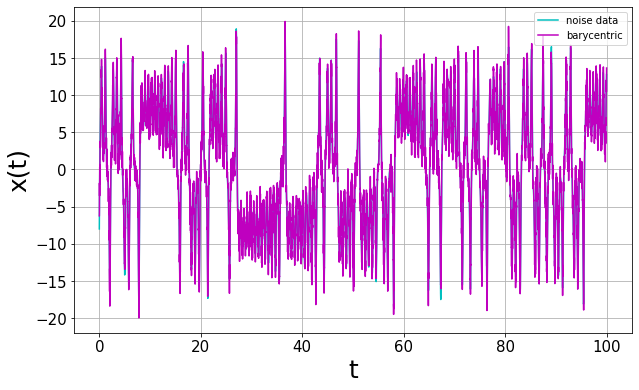

In [14]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_c, x_c, 'c-', label='noise data')
plt.plot(t_eq, xx, 'm-', label='barycentric')
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

Size = 10000

In [15]:
xx_t = FiniteDiff(xx, 0.01, 1)
yy_t = FiniteDiff(yy, 0.01, 1)
zz_t = FiniteDiff(zz, 0.01, 1)

In [18]:
xx_t = FiniteDiff(xx, 0.01, 1)
yy_t = FiniteDiff(yy, 0.01, 1)
zz_t = FiniteDiff(zz, 0.01, 1)

xx = xx.reshape(t_eq.shape[0], 1)
yy = yy.reshape(t_eq.shape[0], 1)
zz = zz.reshape(t_eq.shape[0], 1)

xx_t = xx_t.reshape(t_eq.shape[0], 1)
yy_t = yy_t.reshape(t_eq.shape[0], 1)
zz_t = zz_t.reshape(t_eq.shape[0], 1)

Xn_data = np.hstack([xx,yy,zz])
Xn_ders = np.ones((t_eq.shape[0],1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta, xx_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yy_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zz_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.036159 +0.000000i)y
    + (-8.918955 +0.000000i)x
   
dy/dt = (0.785170 +0.000000i)
    + (8.890120 +0.000000i)y
    + (-11.316132 +0.000000i)x
   
dz/dt = (-1.748753 +0.000000i)
    + (-2.504662 +0.000000i)z
    + (0.964272 +0.000000i)xy
   


In [107]:
w_xn = SINdy(Theta, xx_t, 0.5)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yy_t, 0.5)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zz_t, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.036159 +0.000000i)y
    + (-8.918955 +0.000000i)x
   
dy/dt = (0.785170 +0.000000i)
    + (8.890120 +0.000000i)y
    + (-11.316132 +0.000000i)x
   
dz/dt = (-2.569864 +0.000000i)z
    + (0.964211 +0.000000i)xy
   


Hm...  (0.05-0.09)

In [22]:
w_yn = SINdy(Theta, yy_t, 0.09)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.417426 +0.000000i)y
    + (23.304777 +0.000000i)x
    + (-0.893325 +0.000000i)xz
   


Size = 50000

In [23]:
numpy.random.seed(0)
n = t_c.shape[0]
xc_n = np.zeros(n)
yc_n = np.zeros(n)
zc_n = np.zeros(n)
part = 50;

noise = 1
for i in range(n):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()
#xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
#yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
#zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

t_eq = np.linspace(0, 100, 50000)
length = t_eq.shape[0]
n = 100;
c = np.flip(np.ones(n)*(-1)**np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part
#xx = np.linspace(-1,1,100); 
numer_x = np.zeros(length); 
numer_y = np.zeros(length); 
numer_z = np.zeros(length); 
denom = np.zeros(length);
zeros_1 = np.zeros(length) != 0
zeros_2 = np.zeros(part*n) != 0
#mask = np.zeros(t_eq.shape[0])
for k in range(part):
    for j in range(n): 
        mask =  fabs(t_eq - t_c[n*k+j]) < 10**-6
        if mask.any():
            zeros_1[mask] = True
            zeros_2[n*k+j] = True
        tdiff = t_eq - t_c[100*k+j]; 
        #print(zeros_1[mask], zeros_2[100*k+j])
        temp = c[n*k+j] / tdiff; 
        numer_x = numer_x + temp*xc_n[n*k+j];
        numer_y = numer_y + temp*yc_n[n*k+j]; 
        numer_z = numer_z + temp*zc_n[n*k+j]; 
        denom = denom + temp; 
xx = numer_x/denom; 
yy = numer_y/denom;
zz = numer_z/denom;
xx[zeros_1] = xc_n[zeros_2]
yy[zeros_1] = yc_n[zeros_2]
zz[zeros_1] = zc_n[zeros_2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [25]:
xx_t = FiniteDiff(xx, 0.002, 1)
yy_t = FiniteDiff(yy, 0.002, 1)
zz_t = FiniteDiff(zz, 0.002, 1)

xx = xx.reshape(t_eq.shape[0], 1)
yy = yy.reshape(t_eq.shape[0], 1)
zz = zz.reshape(t_eq.shape[0], 1)

xx_t = xx_t.reshape(t_eq.shape[0], 1)
yy_t = yy_t.reshape(t_eq.shape[0], 1)
zz_t = zz_t.reshape(t_eq.shape[0], 1)

Xn_data = np.hstack([xx,yy,zz])
Xn_ders = np.ones((t_eq.shape[0],1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta, xx_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yy_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zz_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.077980 +0.000000i)y
    + (-8.959071 +0.000000i)x
   
dy/dt = (0.755126 +0.000000i)
    + (8.915150 +0.000000i)y
    + (-11.354612 +0.000000i)x
   
dz/dt = (-1.578856 +0.000000i)
    + (-2.525115 +0.000000i)z
    + (-0.232824 +0.000000i)y
    + (0.200942 +0.000000i)x
    + (0.968642 +0.000000i)xy
   


Varible 'y' depends strongly on the threshold (right terms are defined for 0.085-0.092)

In [26]:
w_yn = SINdy(Theta, yy_t, 0.092)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.387685 +0.000000i)y
    + (23.511246 +0.000000i)x
    + (-0.899686 +0.000000i)xz
   


Sharp jump when changing the threshold from 0.13 up to 0.15 (the zero term increase in absolute value 1.57.. and 48.95..)

In [197]:
w_zn = SINdy(Theta, zz_t, 0.09)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-1.643925 +0.000000i)
    + (-2.522869 +0.000000i)z
    + (0.968555 +0.000000i)xy
   


Size = 100000

In [73]:
numpy.random.seed(0)
n = t_c.shape[0]
xc_n = np.zeros(n)
yc_n = np.zeros(n)
zc_n = np.zeros(n)
part = 50;

noise = 1
for i in range(n):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()
#xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
#yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
#zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

t_eq = np.linspace(0, 100, 100000)
length = t_eq.shape[0]
n = 100;
c = np.flip(np.ones(n)*(-1)**np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part
#xx = np.linspace(-1,1,100); 
numer_x = np.zeros(length); 
numer_y = np.zeros(length); 
numer_z = np.zeros(length); 
denom = np.zeros(length);
zeros_1 = np.zeros(length) != 0
zeros_2 = np.zeros(part*n) != 0
#mask = np.zeros(t_eq.shape[0])
for k in range(part):
    for j in range(n): 
        mask =  fabs(t_eq - t_c[n*k+j]) < 10**-6
        if mask.any():
            zeros_1[mask] = True
            zeros_2[n*k+j] = True
        tdiff = t_eq - t_c[100*k+j]; 
        #print(zeros_1[mask], zeros_2[100*k+j])
        temp = c[n*k+j] / tdiff; 
        numer_x = numer_x + temp*xc_n[n*k+j];
        numer_y = numer_y + temp*yc_n[n*k+j]; 
        numer_z = numer_z + temp*zc_n[n*k+j]; 
        denom = denom + temp; 
xx = numer_x/denom; 
yy = numer_y/denom;
zz = numer_z/denom;
xx[zeros_1] = xc_n[zeros_2]
yy[zeros_1] = yc_n[zeros_2]
zz[zeros_1] = zc_n[zeros_2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [74]:
xx_t = FiniteDiff(xx, 0.001, 1)
yy_t = FiniteDiff(yy, 0.001, 1)
zz_t = FiniteDiff(zz, 0.001, 1)

xx = xx.reshape(t_eq.shape[0], 1)
yy = yy.reshape(t_eq.shape[0], 1)
zz = zz.reshape(t_eq.shape[0], 1)

xx_t = xx_t.reshape(t_eq.shape[0], 1)
yy_t = yy_t.reshape(t_eq.shape[0], 1)
zz_t = zz_t.reshape(t_eq.shape[0], 1)

Xn_data = np.hstack([xx,yy,zz])
Xn_ders = np.ones((t_eq.shape[0],1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data, Xn_ders, Xn_ders_descr, 5, data_description = ['x','y','z'])
    
w_xn = SINdy(Theta, xx_t, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yy_t, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zz_t, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (9.091998 +0.000000i)y
    + (-8.973542 +0.000000i)x
   
dy/dt = (0.373333 +0.000000i)
    + (20.257828 +0.000000i)y
    + (-6.240880 +0.000000i)x
    + (-0.619150 +0.000000i)yz
   
dz/dt = (-1.569454 +0.000000i)
    + (-2.528993 +0.000000i)z
    + (-0.260908 +0.000000i)y
    + (0.236959 +0.000000i)x
    + (0.970143 +0.000000i)xy
   


Remarkable, the x-equation gets better and better every time

In [29]:
w_yn = SINdy(Theta, yy_t, 0.25)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zz_t, 0.25)
print_pde(w_zn, description, ut='dz/dt')

dy/dt = (0.373333 +0.000000i)
    + (20.257828 +0.000000i)y
    + (-6.240880 +0.000000i)x
    + (-0.619150 +0.000000i)yz
   
dz/dt = (-1.641913 +0.000000i)
    + (-2.526350 +0.000000i)z
    + (0.970061 +0.000000i)xy
   


In [30]:
w_zn = SINdy(Theta, zz_t, 0.3)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-1.641913 +0.000000i)
    + (-2.526350 +0.000000i)z
    + (0.970061 +0.000000i)xy
   


The nonlinear term isn't captured or right

In [31]:
w_yn = SINdy(Theta, yy_t, 0.09)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (20.259575 +0.000000i)y
    + (-6.238722 +0.000000i)x
    + (-0.619216 +0.000000i)yz
   


### Data mismatch

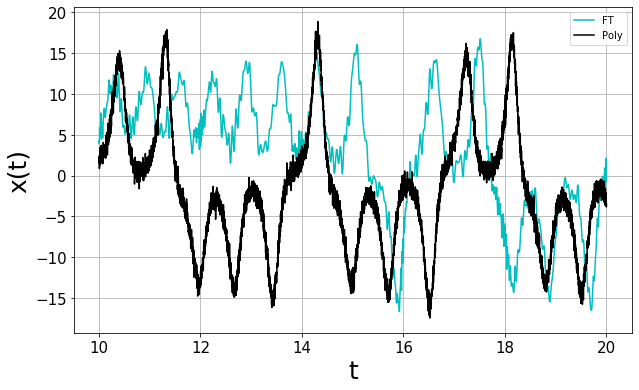

In [36]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_eq[10005:20005], xx[10005:20005], 'c-', label='bary')
plt.plot(t[10005:20005], inter_x[10000:20000],'black',label='Poly')
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

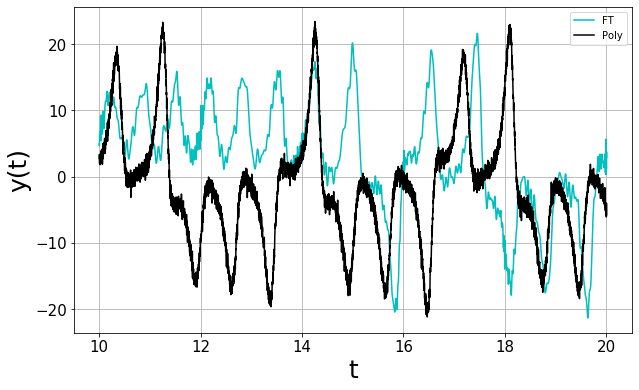

In [37]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_eq[10005:20005], yy[10005:20005], 'c-', label='bary')
plt.plot(t[10005:20005], inter_y[10000:20000],'black',label='Poly')
plt.xlabel('t', fontsize=25)
plt.ylabel('y(t)', fontsize=25)
plt.legend(loc='best')

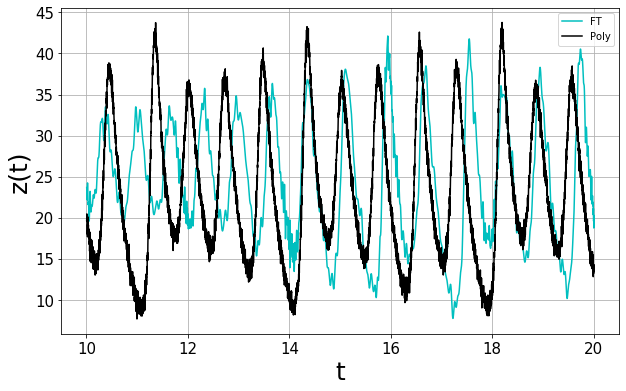

In [272]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_eq[10005:20005], zz[10005:20005], 'c-', label='bary')
plt.plot(t[10005:20005], inter_z[10000:20000],'black',label='Poly')
plt.xlabel('t', fontsize=25)
plt.ylabel('z(t)', fontsize=25)
plt.legend(loc='best')

Maybe, it needs more nodes for interpolation!

### The another way to calculate derivatives 

In [71]:
numpy.random.seed(0)
length = t_c.shape[0]
xc_n = np.zeros(length)
yc_n = np.zeros(length)
zc_n = np.zeros(length)
part = 50;

noise = 1
for i in range(length):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()
    
n = 100;
c = np.ones(n)*(-1)**np.flip(np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part
#xx = np.linspace(-1,1,100); 
l = np.zeros(length); 
xl_t = np.zeros(length); 
yl_t = np.zeros(length);
zl_t = np.zeros(length);

for i in range(length): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(t_c[i] - t_c[:i])
    l[i+1:] = c[i+1:]/c[i]/(t_c[i] - t_c[i+1:])
    l[i] = - sum(l)
    # dx/dt = sum(xj*lj)
    xl_t[i] = xc_n.dot(l) 
    
    # dy/dt = sum(yj*lj)
    yl_t[i] = yc_n.dot(l) 
    
    # dz/dt = sum(zj*lj)
    zl_t[i] = zc_n.dot(l) 


Hm, differentiation of Polynomial Interpolants isn't good. FT work better looking on the plot

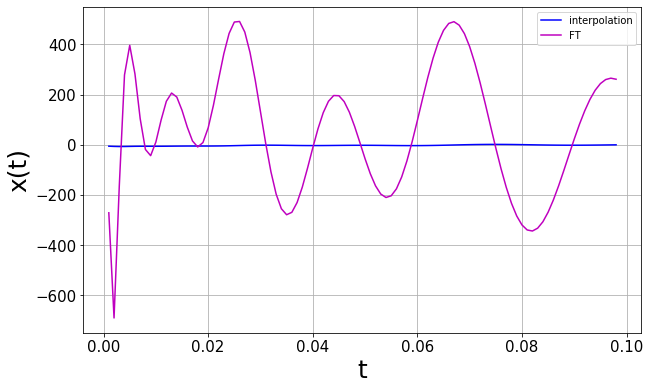

In [80]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.plot(t_c[1:99], xc_n[1:99], 'black', label='noise data')
#plt.plot(t_c[1:99], xl_t[1:99],'c-', label='derivative of interpolation', alpha=0.6)
plt.plot(t_eq[1:99], xx[1:99], 'b', label='interpolation')
plt.plot(t_eq[1:99], xx_t[1:99].real, 'm-', label='FT')
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

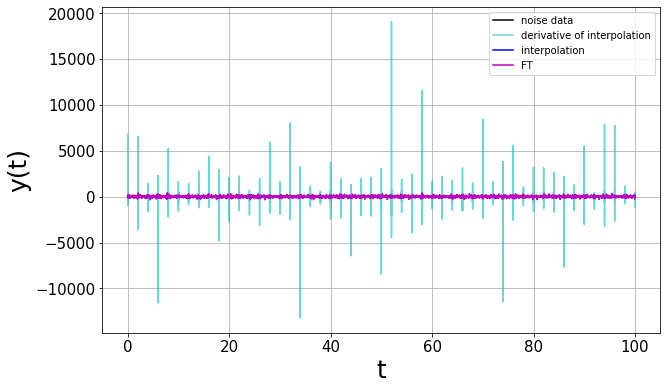

In [19]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_c, y_c, 'black', label='noise data')
plt.plot(t_c, yl_t,'c-', label='derivative of interpolation', alpha=0.6)
plt.plot(t_eq, yy, 'b', label='interpolation')
plt.plot(t_eq, yy_t.real, 'm-', label='FT')
plt.xlabel('t', fontsize=25)
plt.ylabel('y(t)', fontsize=25)
plt.legend(loc='best')

Find out how many nodes it needs in order to interpolate

### Example: cos(x) for barycentric interpolation

Without noise

In [13]:
np.random.seed(0)
n = 1000;
#part = 100;# count of segments formed the segment [0,10]
cos = np.zeros(n+1)
nodes = np.zeros(n+1)

nodes = 5*np.cos(np.pi*np.flip(np.arange(0,n+1)/n)) + 5
#noise = 1
for i in range(n+1):
    cos[i] = np.cos(nodes[i]) 

s = np.linspace(0, 10, 1000)
length = s.shape[0]

c = np.flip(np.ones(n+1)*(-1)**np.arange(0,n+1));
c[0] = 0.5*(-1)**n
c[n] = 0.5

numer = np.zeros(length); 
denom = np.zeros(length);
cos_b = np.zeros(length);
close_mask = np.zeros(length) != 0

for j in range(n+1): 
    mask =  np.fabs(s - nodes[j]) < 10**-6
    if mask.any():
        close_mask[mask] = True
        cos_b[mask] = cos[j]
    sdiff = s - nodes[j]; 
    temp = c[j] / sdiff; 
    numer = numer + temp*cos[j];
    denom = denom + temp; 
cos_b[~close_mask] = numer[~close_mask]/denom[~close_mask]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [15]:
cos_b.shape

(1000,)

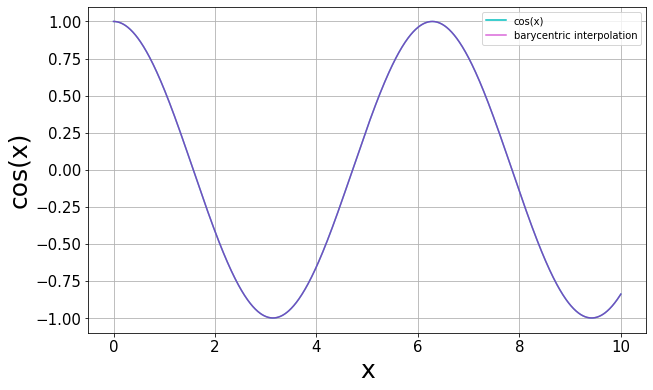

In [17]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.cos(s), 'c-', label='cos(x)')
plt.plot(s, cos_b,'m-', label='barycentric interpolation', alpha=0.6)
plt.xlabel('x', fontsize=25)
plt.ylabel('cos(x)', fontsize=25)
plt.legend(loc='best')

Derivative of cos(x)

In [15]:
np.random.seed(0)
n = 100;
nodes = np.cos(np.pi*np.flip(np.arange(0,n+1)/n))
nod_len = nodes.shape[0]
cos = np.zeros(nod_len) 

for i in range(nod_len):
    cos[i] = np.cos(nodes[i]) 
    
c = np.flip(np.ones(n+1)*(-1)**np.arange(0,n+1));
c[0] = 0.5*(-1)**n
c[n] = 0.5

l = np.zeros(nod_len); 
d_cos = np.zeros(nod_len); 

for i in range(nod_len): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(nodes[i] - nodes[:i])
    l[i+1:] = c[i+1:]/c[i]/(nodes[i] - nodes[i+1:])
    l[i] = - sum(l)
    d_cos[i] = cos.dot(l) 

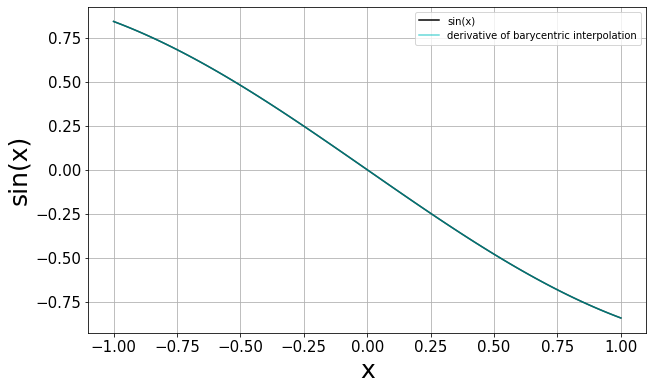

In [17]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(nodes, -np.sin(nodes), 'black', label='sin(x)')
plt.plot(nodes, d_cos,'c-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('x', fontsize=25)
plt.ylabel('sin(x)', fontsize=25)
plt.legend(loc='best')

Derivative of sin(x)

In [13]:
np.random.seed(0)
n = 100;
nodes = np.cos(np.pi*np.flip(np.arange(0,n+1)/n))
nod_len = nodes.shape[0]
sin = np.zeros(nod_len) 

for i in range(nod_len):
    sin[i] = np.sin(nodes[i]) 
    
c = np.flip(np.ones(n+1)*(-1)**np.arange(0,n+1));
c[0] = 0.5*(-1)**n
c[n] = 0.5

l = np.zeros(nod_len); 
d_sin = np.zeros(nod_len); 

for i in range(nod_len): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(nodes[i] - nodes[:i])
    l[i+1:] = c[i+1:]/c[i]/(nodes[i] - nodes[i+1:])
    l[i] = - sum(l)
    d_sin[i] = sin.dot(l)

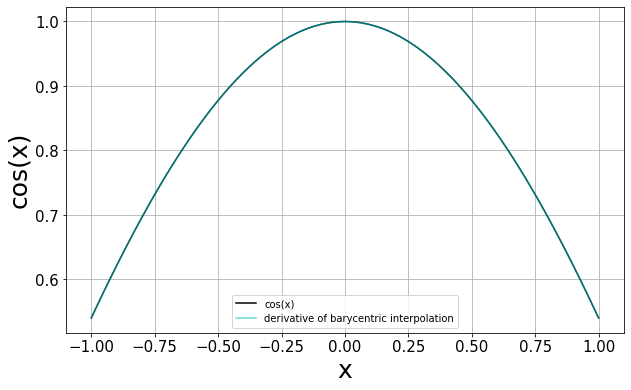

In [14]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(nodes, np.cos(nodes), 'black', label='cos(x)')
plt.plot(nodes, d_sin,'c-', label='derivative of barycentric interpolation', alpha=0.6)
plt.xlabel('x', fontsize=25)
plt.ylabel('cos(x)', fontsize=25)
plt.legend(loc='best')

With noise

In [22]:
numpy.random.seed(0)
n = 100;
nodes = np.cos(np.pi*np.arange(0,n+1)/n)
nod_len = nodes.shape[0]
cos_n = np.zeros(nod_len)


noise = 1
for i in range(nod_len):
    cos_n[i] = np.cos(nodes[i]) + noise*np.random.randn()
    
c = np.ones(n+1)*(-1)**np.arange(0,n+1);
c[0] = 0.5
c[n] = 0.5*(-1)**n

l = np.zeros(nod_len); 
d_cos = np.zeros(nod_len); 

for i in range(nod_len): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(nodes[i] - nodes[:i])
    l[i+1:] = c[i+1:]/c[i]/(nodes[i] - nodes[i+1:])
    l[i] = - sum(l)
    d_cos[i] = cos_n.dot(l) 

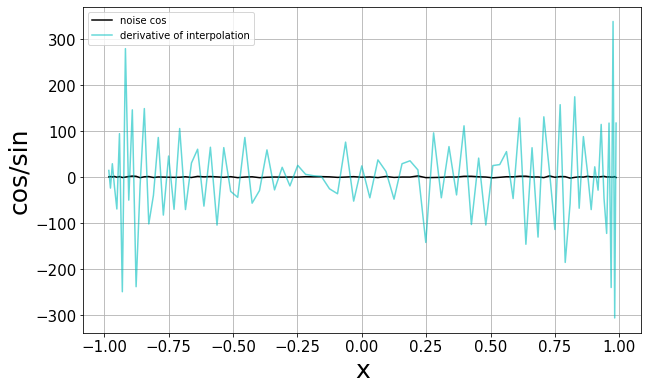

In [25]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(nodes[5:95], cos_n[5:95], 'black', label='noise cos')
plt.plot(nodes[5:95], d_cos[5:95],'c-', label='derivative of interpolation', alpha=0.6)
plt.xlabel('x', fontsize=25)
plt.ylabel('cos/sin', fontsize=25)
plt.legend(loc='best')

I think there are many nodes (large degree) so interpolation fails.

In [43]:
numpy.random.seed(0)
n = 100;
part = 5;# count of segments formed the segment [0,10]
cos_n_1 = np.zeros(n*part)
nodes_1 = np.zeros(n*part)

noise = 1
for k in range(part):
    nodes_1[n*k:n*(k+1)] = np.cos(np.pi*np.flip(np.arange(1,n+1)/n)) + 2*k+1
    for i in range(n):
        cos_n_1[n*k+i] = np.cos(nodes_1[n*k+i]) + noise*np.random.randn()

s = np.linspace(0, 10, 1000)
length = s.shape[0]

c = np.flip(np.ones(n)*(-1)**np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part

numer = np.zeros(length); 
denom = np.zeros(length);
zeros_1 = np.zeros(length) != 0
zeros_2 = np.zeros(part*n) != 0
#mask = np.zeros(t_eq.shape[0])
for k in range(part):
    for j in range(n): 
        mask =  fabs(s - nodes_1[n*k+j]) < 10**-6
        if mask.any():
            zeros_1[mask] = True
            zeros_2[n*k+j] = True
        sdiff = s - nodes_1[n*k+j]; 
        temp = c[n*k+j] / sdiff; 
        numer = numer + temp*cos_n_1[n*k+j];
        denom = denom + temp; 
inter_cos_1 = numer/denom; 
inter_cos_1[zeros_1] = cos_n_1[zeros_2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


It's bad to divide the segment on pieces.

In [139]:
numpy.random.seed(0)
n = 1000;
#part = 100;# count of segments formed the segment [0,10]
cos_n = np.zeros(n+1)
nodes = np.zeros(n+1)

nodes = 5*np.cos(np.pi*np.flip(np.arange(0,n+1)/n)) + 5
noise = 1
for i in range(n+1):
    cos_n[i] = np.cos(nodes[i]) + noise*np.random.randn()

s = np.linspace(0, 10, 1000)
length = s.shape[0]

c = np.flip(np.ones(n+1)*(-1)**np.arange(0,n+1));
c[0] = 0.5*(-1)**n
c[n] = 0.5

numer = np.zeros(length); 
denom = np.zeros(length);
cos_b = np.zeros(length);
close_mask = np.zeros(length) != 0

for j in range(n+1): 
    mask =  fabs(s - nodes[j]) < 10**-6
    if mask.any():
        close_mask[mask] = True
        cos_b[mask] = cos_n[j]
    sdiff = s - nodes[j]; 
    temp = c[j] / sdiff; 
    numer = numer + temp*cos_n[j];
    denom = denom + temp; 
cos_b[~close_mask] = numer[~close_mask]/denom[~close_mask]; 
deg = 4;
width = 5;
inter_cos = np.zeros(n-2*width)
for j in range(width, n-width):

    points = np.arange(j - width+1, j + width)

        # Fit to a Chebyshev polynomial
        # this is the same as any polynomial since we're on a fixed grid but it's better conditioned :)
    inter_cos[j - width] = np.polynomial.chebyshev.Chebyshev.fit(nodes[points],cos_n[points],deg)(nodes[j])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


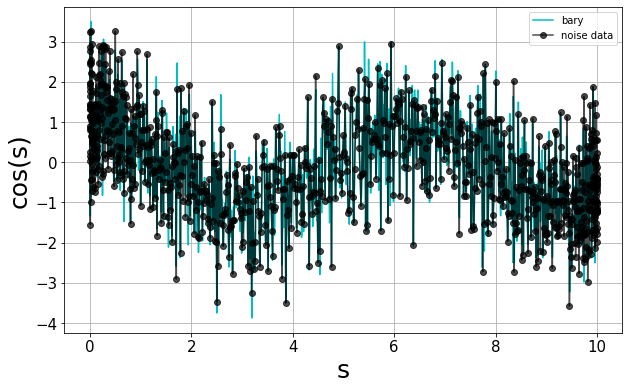

In [158]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, cos_b, 'c-', label='bary')
plt.plot(nodes, cos_n, 'black', label='noise data', marker = 'o',alpha=0.7)
#plt.plot(s, inter_cos_1,'c-', label='interpolation_1')
#plt.plot(nodes[width:n-width], inter_cos,'m-', label='Poly', alpha=0.6)
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

In [65]:
numpy.random.seed(0)
n = t_c.shape[0]
xc_n = np.zeros(n)
yc_n = np.zeros(n)
zc_n = np.zeros(n)
part = 1000;
 
noise = 1
for i in range(n):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()
#xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
#yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
#zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

t_eq = np.linspace(0, 100, 10000)
length = t_eq.shape[0]
n = 10;
c = np.ones(n)*(-1)**np.flip(np.arange(1,n+1));
c[0] = 0.5*(-1)**n
c = list(c)*part
#xx = np.linspace(-1,1,100); 
numer_x = np.zeros(length); 
numer_y = np.zeros(length); 
numer_z = np.zeros(length); 
denom = np.zeros(length);
zeros_1 = np.zeros(length) != 0
zeros_2 = np.zeros(part*n) != 0

for k in range(part):
    for j in range(n): 
        mask =  fabs(t_eq - t_c[n*k+j]) < 10**-6
        if mask.any():
            zeros_1[mask] = True
            zeros_2[n*k+j] = True
        tdiff = t_eq - t_c[n*k+j]; 
        
        temp = c[n*k+j] / tdiff; 
        numer_x = numer_x + temp*xc_n[n*k+j];
        numer_y = numer_y + temp*yc_n[n*k+j]; 
        numer_z = numer_z + temp*zc_n[n*k+j]; 
        denom = denom + temp; 
xx = numer_x/denom; 
yy = numer_y/denom;
zz = numer_z/denom;
xx[zeros_1] = xc_n[zeros_2]
yy[zeros_1] = yc_n[zeros_2]
zz[zeros_1] = zc_n[zeros_2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [66]:
length = t_c.shape[0]

l = np.zeros(length); 
xl_t = np.zeros(length); 
yl_t = np.zeros(length);
zl_t = np.zeros(length);

for i in range(length): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(t_c[i] - t_c[:i])
    l[i+1:] = c[i+1:]/c[i]/(t_c[i] - t_c[i+1:])
    l[i] = - sum(l)
    # dx/dt = sum(xj*lj)
    xl_t[i] = xc_n.dot(l) 
    
    # dy/dt = sum(yj*lj)
    yl_t[i] = yc_n.dot(l) 
    
    # dz/dt = sum(zj*lj)
    zl_t[i] = zc_n.dot(l) 


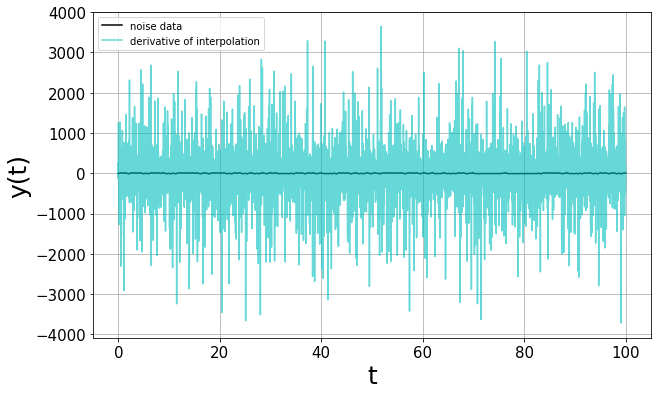

In [67]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_c, x_c, 'black', label='noise data')
plt.plot(t_c, xl_t,'c-', label='derivative of interpolation', alpha=0.6)
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

Thus, jumps take places at the segment ends. So take the whole segment.

In [117]:
numpy.random.seed(0)
n = t_c.shape[0]
xc_n = np.zeros(n)
yc_n = np.zeros(n)
zc_n = np.zeros(n)
#part = 1000;
 
noise = 1
for i in range(n):
    xc_n[i] = x_c[i] + noise*np.random.randn()
    yc_n[i] = y_c[i] + noise*np.random.randn()
    zc_n[i] = z_c[i] + noise*np.random.randn()
#xn_t = FiniteDiff(inter_x, dt, 1).reshape(size - 2*width, 1)
#yn_t = FiniteDiff(inter_y, dt, 1).reshape(size - 2*width, 1)
#zn_t = FiniteDiff(inter_z, dt, 1).reshape(size - 2*width, 1)

t_eq = np.linspace(0, 100, 100000)
length = t_eq.shape[0]
c = np.ones(n)*(-1)**np.flip(np.arange(0,n));
c[0] = 0.5*(-1)**(n-1)
c[n-1] = 0.5
#c = list(c)*part
#xx = np.linspace(-1,1,100); 
numer_x = np.zeros(length); 
numer_y = np.zeros(length); 
numer_z = np.zeros(length); 
denom = np.zeros(length);
close_mask = np.zeros(length) != 0
#zeros_2 = np.zeros(n) != 0
xx = np.zeros(length);
yy = np.zeros(length);
zz = np.zeros(length);


for j in range(n): 
    mask =  fabs(t_eq - t_c[j]) < 10**-6
    if mask.any():
        close_mask[mask] = True
        xx[mask] = xc_n[j]
        yy[mask] = yc_n[j]
        zz[mask] = zc_n[j]
    
    tdiff = t_eq - t_c[j]; 
    temp = c[j] / tdiff; 
    numer_x = numer_x + temp*xc_n[j];
    numer_y = numer_y + temp*yc_n[j]; 
    numer_z = numer_z + temp*zc_n[j]; 
    denom = denom + temp; 
xx[~close_mask] = numer_x[~close_mask]/denom[~close_mask]; 
yy[~close_mask] = numer_y[~close_mask]/denom[~close_mask];
zz[~close_mask] = numer_z[~close_mask]/denom[~close_mask];

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


In [123]:
length = t_c.shape[0]

l = np.zeros(length); 
xl_t = np.zeros(length); 
yl_t = np.zeros(length);
zl_t = np.zeros(length);

for i in range(length): 
    l[i] = 0
    l[:i] = c[:i]/c[i]/(t_c[i] - t_c[:i])
    l[i+1:] = c[i+1:]/c[i]/(t_c[i] - t_c[i+1:])
    l[i] = - sum(l)
    # dx/dt = sum(xj*lj)
    xl_t[i] = xc_n.dot(l) 
    
    # dy/dt = sum(yj*lj)
    yl_t[i] = yc_n.dot(l) 
    
    # dz/dt = sum(zj*lj)
    zl_t[i] = zc_n.dot(l) 

In [168]:
t_c.shape

(100001,)

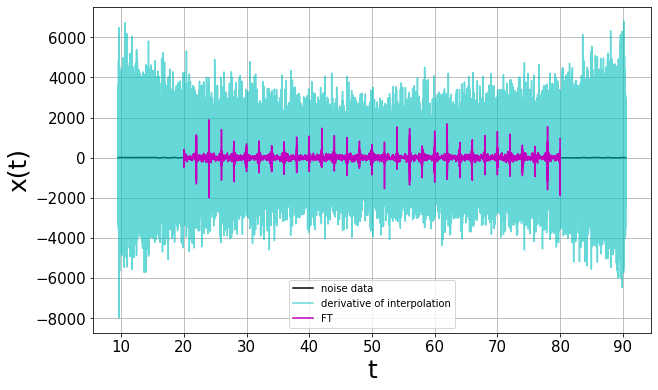

In [138]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t_c[20000:80000], x_c[20000:80000], 'black', label='noise data')
plt.plot(t_c[20000:80000], xl_t[20000:80000],'c-', label='derivative of interpolation', alpha=0.6)
plt.plot(t_eq[20000:80000], xx_t[20000:80000].real, 'm-', label='FT')
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

The result didn't meet expectations...

### Data mismatch

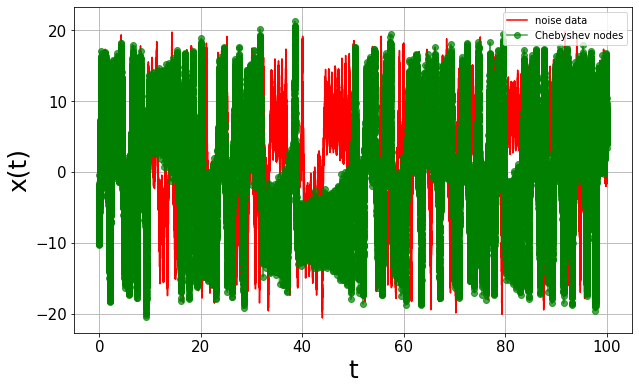

In [179]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t, xn,'r',label='noise data')
plt.plot(t_c, xc_n,'g', marker = 'o', label='Chebyshev nodes', alpha=0.7)

#plt.plot(t_eq[:10000], xx[:10000], 'black', label='bary')
#plt.plot(t[5:10005], inter_x[:10000],'c',label='Poly',alpha=0.4)
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

Clean data

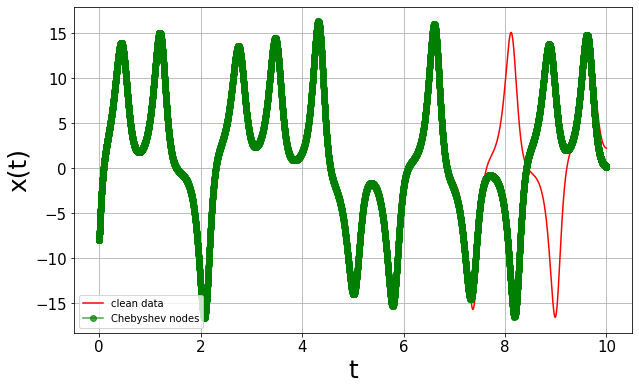

In [187]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[:10000], x[:10000],'r',label='clean data')
plt.plot(t_c, x_c,'g', marker = 'o', label='Chebyshev nodes', alpha=0.7)

#plt.plot(t_eq[:10000], xx[:10000], 'black', label='bary')
#plt.plot(t[5:10005], inter_x[:10000],'c',label='Poly',alpha=0.4)
plt.xlabel('t', fontsize=25)
plt.ylabel('x(t)', fontsize=25)
plt.legend(loc='best')

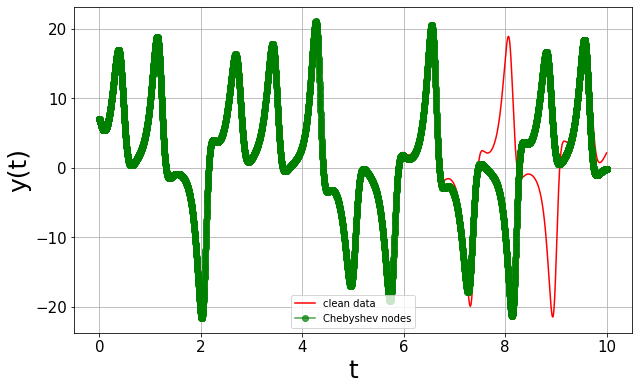

In [188]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[:10000], y[:10000],'r',label='clean data')
plt.plot(t_c, y_c,'g', marker = 'o', label='Chebyshev nodes', alpha=0.7)

#plt.plot(t_eq[:10000], xx[:10000], 'black', label='bary')
#plt.plot(t[5:10005], inter_x[:10000],'c',label='Poly',alpha=0.4)
plt.xlabel('t', fontsize=25)
plt.ylabel('y(t)', fontsize=25)
plt.legend(loc='best')

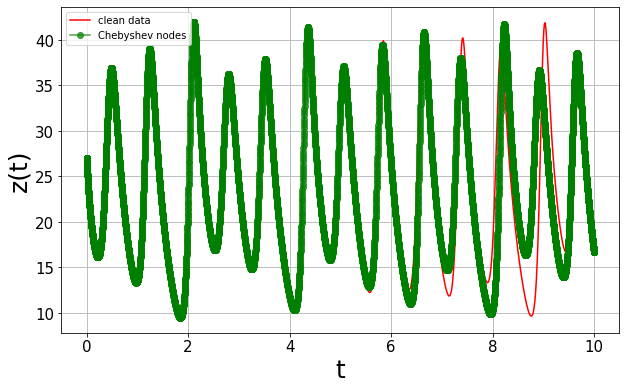

In [189]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(t[:10000], z[:10000],'r',label='clean data')
plt.plot(t_c, z_c,'g', marker = 'o', label='Chebyshev nodes', alpha=0.7)

#plt.plot(t_eq[:10000], xx[:10000], 'black', label='bary')
#plt.plot(t[5:10005], inter_x[:10000],'c',label='Poly',alpha=0.4)
plt.xlabel('t', fontsize=25)
plt.ylabel('z(t)', fontsize=25)
plt.legend(loc='best')

It's seen that at the ends Poly and Barycentric interpolation coinsides (especially, in the beginning), but at the other parts they different. Probably, it associates with Chebyshev nodes.

The built-in method doesn't work

In [255]:
#t_eq = np.linspace(0, 100, 10000)
bary_x = barycentric_interpolate(t_c, xc_n, t_eq)
bary_y = barycentric_interpolate(t_c, yc_n, t_eq)
bary_z = barycentric_interpolate(t_c, zc_n, t_eq)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:512: RuntimeWarning: overflow encountered in reduce
  self.wi[j] = np.multiply.reduce(self.xi[:j]-self.xi[j])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:511: RuntimeWarning: overflow encountered in multiply
  self.wi[:j] *= (self.xi[j]-self.xi[:j])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:609: RuntimeWarning: invalid value encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


## TikhonovDiff

In [215]:
from scipy.sparse import csc_matrix
from scipy.sparse import linalg as spla
import scipy

In [216]:
def TikhonovDiff_modified(f, dx, lam, d = 1):
    """
    Tikhonov differentiation.

    return argmin_g \|Ag-f\|_2^2 + lam*\|Dg\|_2^2
    where A is trapezoidal integration and D is finite differences for first dervative

    It looks like it will work well and does for the ODE case but 
    tends to introduce too much bias to work well for PDEs.  If the data is noisy, try using
    polynomials instead.
    """

    # Initialize a few things    
    n = len(f)
    f = np.array(f - f[0])

    # Get a trapezoidal approximation to an integral
    #A = csc_matrix((n,n)) - expensive
    A = scipy.sparse.lil_matrix((n,n))
    for i in range(1, n):
        A[i,0] = dx/2
        for j in range(1,i): A[i,j] = dx
        A[i,i] = dx/2
    #A = csc_matrix(A)
    e = np.ones(n-1)/dx
    D = sparse.diags([e, -e], [1, 0], shape=(n-1, n))
    
    # Invert to find derivative
    g = spla.lsqr(A.T.dot(A) + lam*D.T.dot(D), A.T.dot(f))[0]
    if d == 1: return g

    # If looking for a higher order derivative, this one should be smooth so now we can use finite differences
    else: return FiniteDiff(g, dx, d-1)

In [ ]:
lam = 10**8
xt = TikhonovDiff_modified(x, dt, lam, d = 1)

It's important to choose lam for TD

## Example:  cos(x)

Without noise

In [18]:
s = np.linspace(-10, 10, 2000)
sin = np.sin(s)
ds = 0.01
cos_T = TikhonovDiff(sin, ds, 7**-2)
l = len(s)
boundary = 5 # as well as Navier-Stokes
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
cos_P = np.zeros(1990)

for p in range(l - 10):
    j = p + 5
    cos_P[p] = PolyDiffPoint(sin[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*ds, deg, 1)[0]

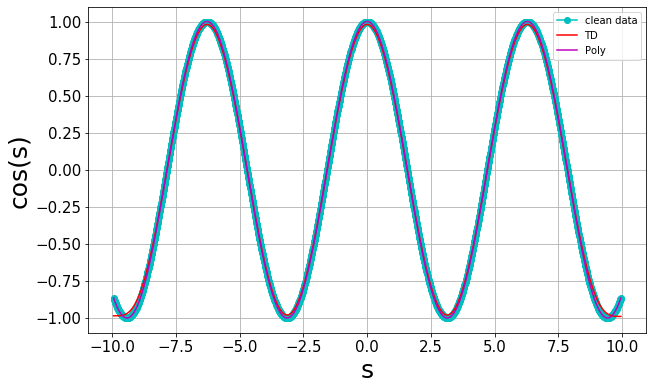

In [19]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[5:1995], np.cos(s[5:1995]), 'c-o', label='clean data')
plt.plot(s[5:1995], real(cos_T[5:1995]),'r-',label='TD')
plt.plot(s[5:1995], real(cos_P),'m-',label='Poly')
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

In [6]:
s = np.linspace(-10, 10, 200)
sin = np.sin(s)
ds = 0.1
l = len(s)
boundary = 5
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4
cos_P = np.zeros(l-10)

for p in range(l-10):
    j = p + 5
    cos_P[p] = PolyDiffPoint(sin[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*ds, deg, 1)[0] 
bary = barycentric_interpolate(s, sin,s)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.sin(s), 'c-', label='clean data')
plt.plot(s, bary,'g-',label='Barycentric')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

In [11]:
np.linalg.norm(bary-np.sin(s))

0.0

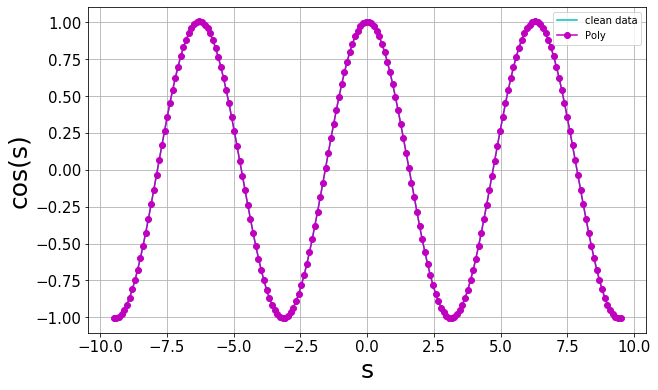

In [44]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[5:l-5], np.cos(s[5:l-5]), 'c-', label='clean data')
plt.plot(s[5:l-5], real(cos_P),'m-o',label='Poly')
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

In [39]:
np.linalg.norm(np.cos(s[5:l-5]) - real(cos_P)) # 2-th degree

0.14517788635754544

In [33]:
np.linalg.norm(np.cos(s[5:l-5]) - real(cos_P)) # 3-th degree

0.048627459092044766

In [30]:
np.linalg.norm(np.cos(s[5:l-5]) - real(cos_P)) # 4-th degree 

0.048627459092034524

In [42]:
np.linalg.norm(np.cos(s[5:l-5]) - real(cos_P)) # 5-th degree

0.049289946986923475

In [36]:
np.linalg.norm(np.cos(s[5:l-5]) - real(cos_P)) # 8-th degree

0.04929061821586477

For this example $\lambda = 7^{-2}$ is optimal. Noise = $0.1$

In [21]:
s = np.linspace(-10, 10, 2000)
sin = np.sin(s)
sin_n = np.zeros(2000)
for i in range(len(s)):
    sin_n[i] = sin[i] + 0.1*np.random.randn()
ds = 0.01
cos_T = TikhonovDiff(sin_n, ds, 7**-2)
l = len(s)
boundary = 5 # as well as Navier-Stokes
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
cos_P = np.zeros(1990)

for p in range(l - 10):
    j = p + 5
    cos_P[p] = PolyDiffPoint(sin_n[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*ds, deg, 1)[0]

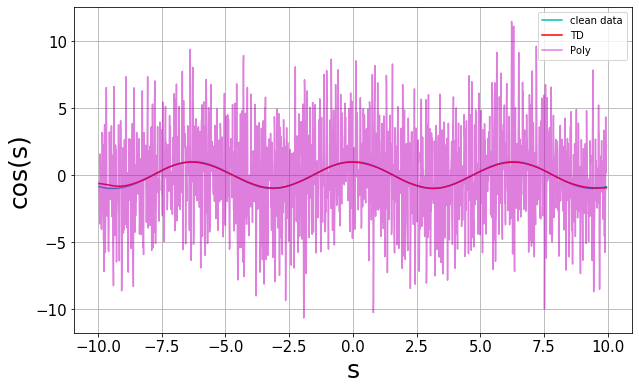

In [22]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[5:1995], np.cos(s[5:1995]), 'c-', label='clean data')
plt.plot(s[5:1995], real(cos_T[5:1995]),'r-',label='TD')
plt.plot(s[5:1995], real(cos_P),'m-',label='Poly', alpha=0.5)
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

### Barycentric interpolation

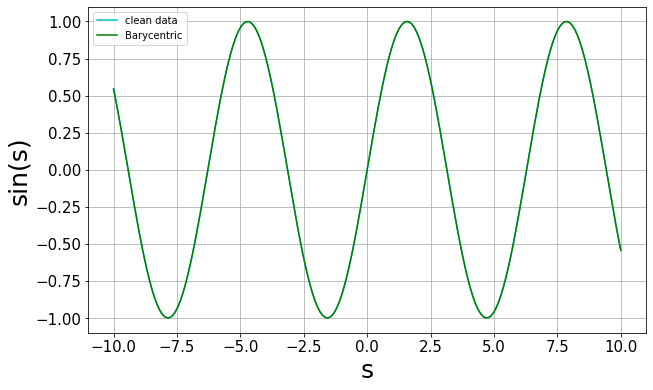

In [209]:
s = np.linspace(-10, 10, 200)
sin = np.sin(s)
ds = 0.1
l = len(s)
boundary = 5
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4
cos_P = np.zeros(l-10)

for p in range(l-10):
    j = p + 5
    cos_P[p] = PolyDiffPoint(sin[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*ds, deg, 1)[0] 
bary = barycentric_interpolate(s, sin,s)
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.sin(s), 'c-', label='clean data')
plt.plot(s, bary,'g-',label='Barycentric')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

In [212]:
s = np.linspace(-10, 10, 200)
sin = np.sin(s)
l = len(s)
sin_n = np.zeros(l)
for i in range(l):
    sin_n[i] = np.sin(s[i]) + 0.1*np.random.randn() 

In [213]:
poly = np.polynomial.chebyshev.Chebyshev.fit(s[1:10],sin_n[1:10],4)
der_poly = poly.deriv(m=1)(s[5])

In [214]:
poly

Chebyshev([ 0.06185779, -0.40342535,  0.0105652 ,  0.01244627, -0.01982859], domain=[-9.89949749, -9.09547739], window=[-1.,  1.])

In [70]:
n = 100; 
s = np.linspace(-0.9, 0.9, 1000)
l = len(s)
#sin = np.sin(s)
noise = 1
sin = np.zeros(n)

exts = np.cos(np.pi*np.arange(0,n+1)/n);
c = np.ones(n+1)*(-1)**np.arange(0,n+1);
c[0] = 0.5
c[n] = 0.5*(-1)**(n)
#xx = np.linspace(-1,1,100); 
numer = np.zeros(l); 
denom = np.zeros(l);
for j in range(n): 
    xdiff = s - exts[j]; 
    temp = c[j] / xdiff; 
    sin[j] = np.sin(exts[j]) + noise*np.random.randn()
    numer = numer + temp*sin[j]; 
    denom = denom + temp; 
ff = numer/denom; 

sin_n = np.zeros(l)
for i in range(l):
    sin_n[i] = np.sin(s[i]) + noise*np.random.randn()

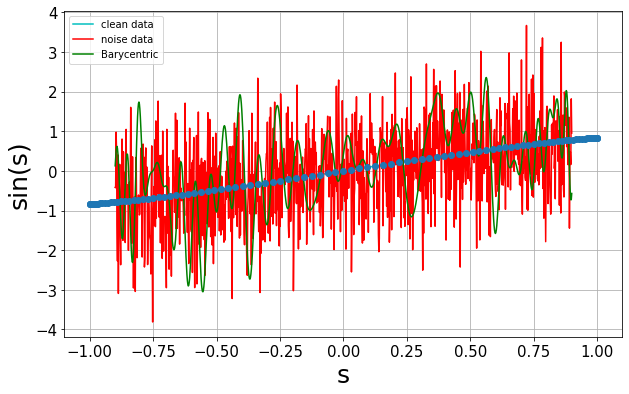

In [71]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.sin(s), 'c-', label='clean data')
plt.plot(s, sin_n,'r-',label='noise data')
plt.plot(s, ff,'g-',label='Barycentric')

plt.plot(exts, np.sin(exts),'o')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

In [29]:
bary = barycentric_interpolate(s, sin_n, s)

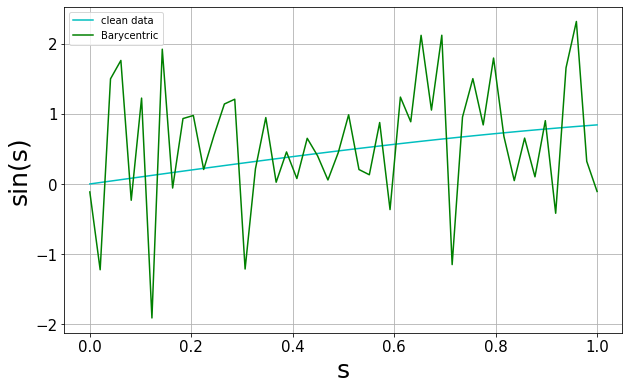

In [30]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.sin(s), 'c-', label='clean data')
plt.plot(s, bary,'g-',label='Barycentric')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

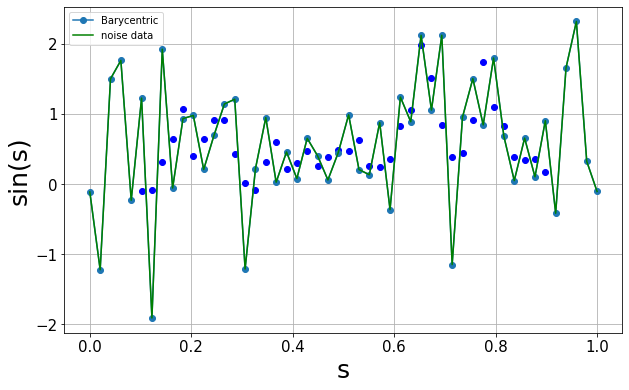

In [33]:
width = 5
poly = {}
der_poly = {}
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
for j in range(width, l-width):
    points = np.arange(j - width + 1, j + width)
    poly[j-width] = np.polynomial.chebyshev.Chebyshev.fit(s[points],sin_n[points],4)
    plt.plot(s[j], poly[j-width](s[j]), 'b-o')
plt.plot(s, bary,'o-',label='Barycentric')
plt.plot(s, sin_n, 'g-', label='noise data')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

In [211]:
s = np.linspace(0, 10, 1000)
l = len(s)
sin = np.sin(s)
sin_n = np.zeros(l)
noise = 1
for i in range(l):
    sin_n[i] = sin[i] + noise*np.random.randn()
ds = 0.01
#cos_T = TikhonovDiff(sin_n, ds, 7**-2)
boundary = 5 # as well as Navier-Stokes
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 3 # degree of polynomial to use
cos_P = np.zeros(l-10)

#for p in range(l - 10):
    #j = p + 5
    #cos_P[p] = PolyDiffPoint(sin_n[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*ds, deg, 1)[0]

### Barycentric and Poly 

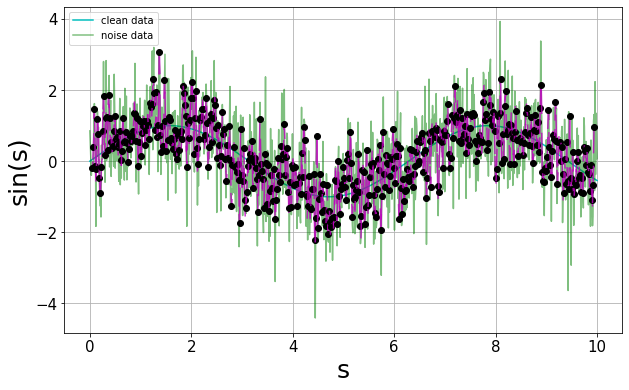

In [14]:
width = 5
poly = {}
#der_poly = {}
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.sin(s), 'c-', label='clean data')
plt.plot(s, sin_n, 'g-', label='noise data', alpha=0.5)
for j in range(width, l-width, 2):
    points = np.arange(j - width + 1, j + width)
    poly[j-width] = np.polynomial.chebyshev.Chebyshev.fit(s[points],sin_n[points], 4)
    plt.plot(s[j-1:j+2], poly[j-width](s[j-1:j+2]), 'm-', alpha=0.8)
    plt.plot(s[j], poly[j-width](s[j]), 'o', color='black')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)', fontsize=25)
plt.legend(loc='best')

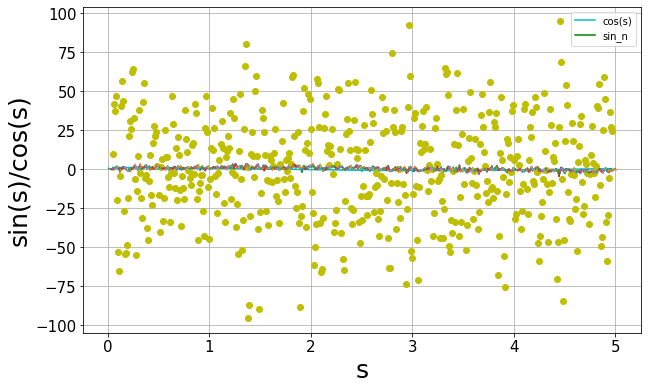

In [23]:
width = 5
poly = {}
der_poly = {}
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[5:(l-5)//2], np.cos(s[5:(l-5)//2]), 'c-', label='cos(s)')
plt.plot(s[5:(l-5)//2], sin_n[5:(l-5)//2], 'g-', label='sin_n')
for j in range(width, (l-width)//2):
    points = np.arange(j - width + 1, j + width)
    poly[j-width] = np.polynomial.chebyshev.Chebyshev.fit(s[points],sin_n[points],4)
    der_poly[j-width] = poly[j-width].deriv(m=1)(s[j])
    plt.plot(s[points], poly[j-width](s[points]))
    plt.plot(s[j], der_poly[j-width], 'y-o')
    #plt.plot(s[j-1:j+2], der_poly[j-width], 'y-o')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)/cos(s)', fontsize=25)
plt.legend(loc='best')

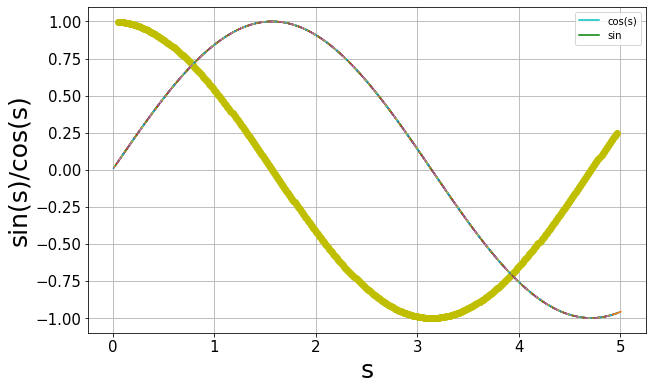

In [21]:
width = 5
poly = {}
der_poly = {}
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[5:(l-5)//2], np.cos(s[5:(l-5)//2]), 'c-', label='cos(s)')
plt.plot(s[5:(l-5)//2], sin[5:(l-5)//2], 'g-', label='sin')
#plt.plot(s[5:(l-5)//2], real(cos_P),'m-o',label='Poly')
for j in range(width, (l-width)//2):
    points = np.arange(j - width + 1, j + width)
    poly[j-width] = np.polynomial.chebyshev.Chebyshev.fit(s[points],sin[points],4)
    der_poly[j-width] = poly[j-width].deriv(m=1)(s[j])
    plt.plot(s[points], poly[j-width](s[points]))
    plt.plot(s[j], der_poly[j-width], 'y-o')
    #plt.plot(s[j-1:j+2], der_poly[j-width], 'y-o')
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)/cos(s)', fontsize=25)
plt.legend(loc='best')

Denoise data and using FD for derivatives

In [ ]:
s = np.linspace(0, 10, 1000)
l = len(s)
sin = np.sin(s)
sin_n = np.zeros(l)
noise = 1
for i in range(l):
    sin_n[i] = sin[i] + noise*np.random.randn()
ds = 0.01
boundary = 5 # as well as Navier-Stokes
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 3 # degree of polynomial to use
cos_P = np.zeros(l-10)

In [26]:
poly = {}
s = np.linspace(0, 10, 1000) 
l = len(s)
ds = 0.01
width = 5
sin = np.sin(s)
sin_n = np.zeros(l)
der_poly = np.zeros(l-2*width)
interpolation = np.zeros(l - 2*width)
noise = 1
for i in range(l):
    sin_n[i] = sin[i] + noise*np.random.randn()

for j in range(width, l-width):
    points = np.arange(j - width + 1, j + width)
    poly[j-width] = np.polynomial.chebyshev.Chebyshev.fit(s[points],sin_n[points], 4)
    der_poly[j-width] = poly[j-width].deriv(m=1)(s[j])   
    interpolation[j-width] = poly[j-width](s[j])
    
bary = barycentric_interpolate(s, sin_n, s[width:l-width])
dif_sin_poly = FiniteDiff(interpolation, ds, 1)
dif_sin_bary = FiniteDiff(bary, ds, 1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:512: RuntimeWarning: overflow encountered in reduce
  self.wi[j] = np.multiply.reduce(self.xi[:j]-self.xi[j])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:511: RuntimeWarning: overflow encountered in multiply
  self.wi[:j] *= (self.xi[j]-self.xi[:j])
C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:609: RuntimeWarning: divide by zero encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


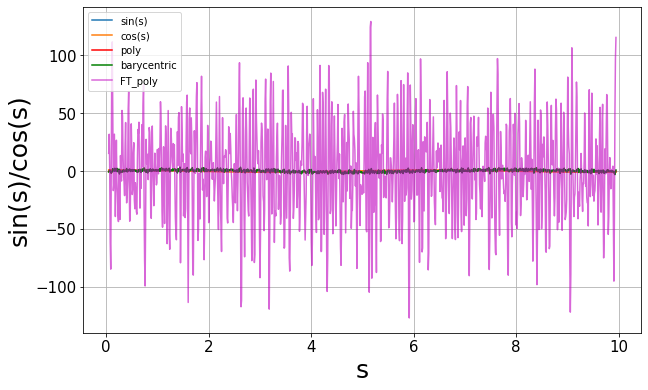

In [30]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[width:l-width], np.sin(s[width:l-width]), label='sin(s)')
plt.plot(s[width:l-width], np.cos(s[width:l-width]), label='cos(s)')
plt.plot(s[width:l-width], interpolation, 'r-', label='poly')
plt.plot(s[width:l-width], bary, 'g-', label='barycentric')
plt.plot(s[width:l-width], dif_sin_poly.real, 'm-', label='FD_poly',alpha=0.6)
plt.xlabel('s', fontsize=25)
plt.ylabel('sin(s)/cos(s)', fontsize=25)
plt.legend(loc='best')

Noise = 1, $\lambda=8^{-2}$

In [38]:
s = np.linspace(-10, 10, 2000)
x = np.sin(s)
x_n = np.zeros(2000)
for i in range(len(s)):
    x_n[i] = x[i] + np.random.randn()
ds = 0.01
cos_T = TikhonovDiff(x_n, ds, 8**-2)

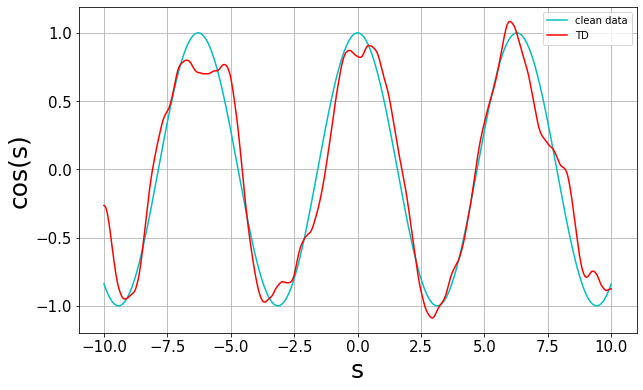

In [40]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s, np.cos(s), 'c-', label='clean data')
plt.plot(s, real(cos_T),'r-',label='TD')
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

$\lambda=10^{-2}$

In [44]:
s = np.linspace(-10, 10, 2000)
x = np.sin(s)
x_n = np.zeros(2000)
for i in range(len(s)):
    x_n[i] = x[i] + np.random.randn()
ds = 0.01
cos_T = TikhonovDiff(x_n, ds, 10**-2)

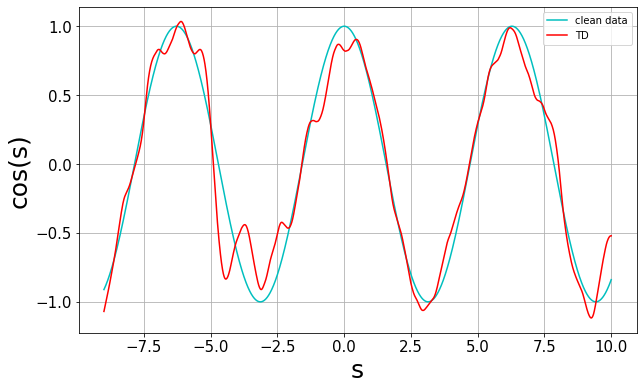

In [45]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(s[100:], np.cos(s[100:]), 'c-', label='clean data')
plt.plot(s[100:], real(cos_T[100:]),'r-',label='TD')
plt.xlabel('s', fontsize=25)
plt.ylabel('cos(s)', fontsize=25)
plt.legend(loc='best')

### Choice of $\lambda$

Without noise

- $\dot x$

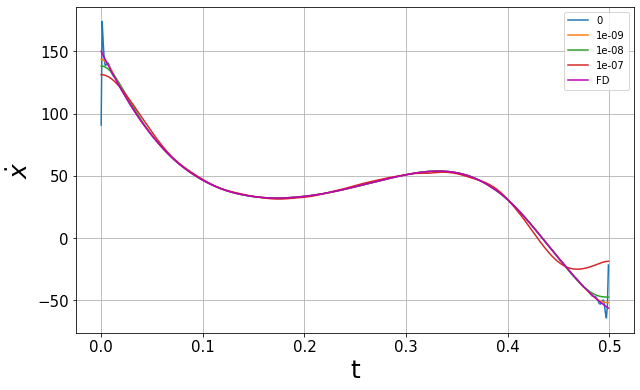

In [107]:
subsample = int(size*0.005)
x_sub = x[:subsample]
y_sub = y[:subsample]
z_sub = z[:subsample]
#noise = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
#for i in range(subsample):
    #xn[i] = x[i] + noise[0]*np.random.randn()
    #yn[i] = y[i] + noise[0]*np.random.randn()
    #zn[i] = z[i] + noise[0]*np.random.randn()

xt_n = FiniteDiff(x_sub, dt, 1)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#lams = np.linspace(10**-8, 10**-7, 4)
lams = [0, 10**-9, 10**-8, 10**-7]
for lam in lams:
    xt_T = TikhonovDiff_modified(x_sub, dt, lam, 1)
    plt.plot(t[:subsample], xt_T, label=lam)

plt.plot(t[:subsample], xt_n, 'm-', label='FD')
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

- $\dot y$

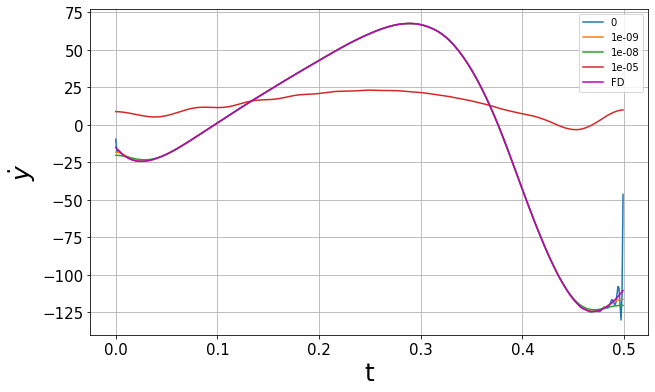

In [108]:
subsample = int(size*0.005)
x_sub = x[:subsample]
y_sub = y[:subsample]
z_sub = z[:subsample]
#noise = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
#for i in range(subsample):
    #xn[i] = x[i] + noise[0]*np.random.randn()
    #yn[i] = y[i] + noise[0]*np.random.randn()
    #zn[i] = z[i] + noise[0]*np.random.randn()

yt_n = FiniteDiff(y_sub, dt, 1)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#lams = np.linspace(10**-9, 10**-8, 4)
lams = [0, 10**-9, 10**-8, 10**-5]
for lam in lams:
    yt_T = TikhonovDiff_modified(y_sub, dt, lam, 1)
    plt.plot(t[:subsample], yt_T, label=lam)

plt.plot(t[:subsample], yt_n.real, 'm-', label='FD')
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot y$', fontsize=25)
plt.legend(loc='best')

- $\dot z$

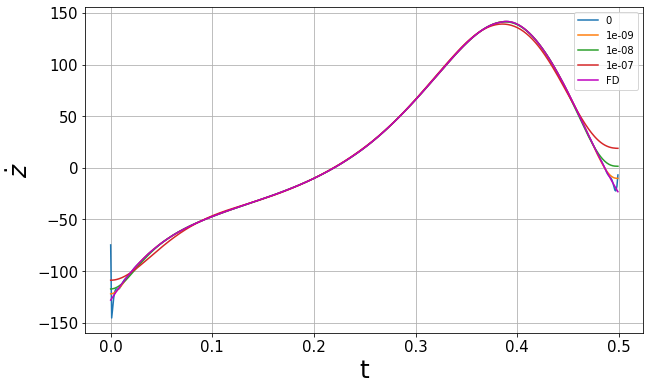

In [109]:
subsample = int(size*0.005)
x_sub = x[:subsample]
y_sub = y[:subsample]
z_sub = z[:subsample]

zt_n = FiniteDiff(z_sub, dt, 1)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
lams = [0, 10**-9, 10**-8, 10**-7]
for lam in lams:
    zt_T = TikhonovDiff_modified(z_sub, dt, lam, 1)
    plt.plot(t[:subsample], zt_T, label=lam)

plt.plot(t[:subsample], zt_n, 'm-', label='FD')
plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot z$', fontsize=25)
plt.legend(loc='best')

## Comparison FD, Poly and TD

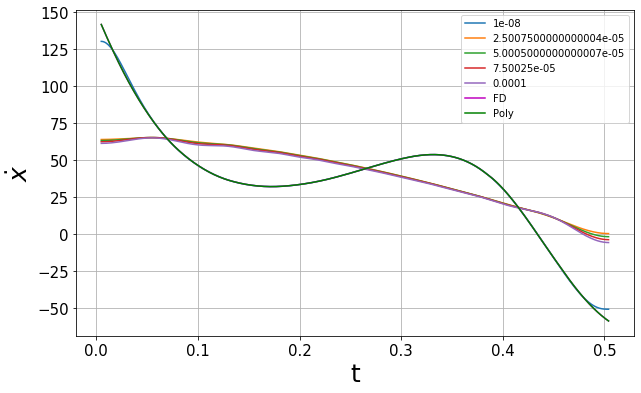

In [128]:
boundary = 5
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
subsample = int(size*0.005)
x_sub = x[:subsample + 10].T[0]
#y_sub = y[:subsample + 10].T[0]
#z_sub = z[:subsample + 10].T[0]

xt_P = np.zeros(subsample)
xt_FD = np.zeros(subsample)

for p in range(subsample):
    j = p + 5
    xt_P[p] = PolyDiffPoint(x_sub[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

xt_FD = FiniteDiff(x_sub[5:subsample + 5], dt, 1)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
lams = np.linspace(10**-9, 10**-4, 5)
for lam in lams:
    xt_T = TikhonovDiff_modified(x_sub[5:subsample + 5], dt, lam, 1)
    plt.plot(t[5:subsample + 5], xt_T, label=lam)

plt.plot(t[5:subsample + 5], xt_FD, 'm-', label='FD')
plt.plot(t[5:subsample + 5], xt_P, 'g-', label='Poly')

plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

### Without noise

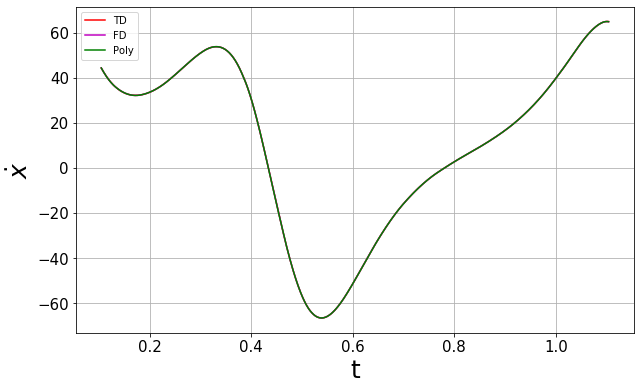

In [113]:
boundary = 5
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
subsample = int(size*0.01)

x_sub = x[100:subsample + 110]
#y_sub = y[100:subsample + 110]
#z_sub = z[100:subsample + 110]

xt_P = np.zeros(subsample)
xt_FD = np.zeros(subsample)

for p in range(subsample):
    j = p + 5
    xt_P[p] = PolyDiffPoint(x_sub[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

xt_FD = FiniteDiff(x[105:subsample + 105], dt, 1)


lam = 10**-9
xt_T = TikhonovDiff_modified(x[:subsample+210], dt, lam, 1)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.plot(t[105:subsample+105], xt_T[105:subsample+105], 'r-', label='TD')
plt.plot(t[105:subsample+105], real(xt_FD), 'm-', label='FD')
plt.plot(t[105:subsample+105], real(xt_P), 'g-', label='Poly')

plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

In [115]:
boundary = 5
# number of points to use in fitting
Nt = 2*boundary-1 
subsample = int(size*0.01)

x_sub = x[105:subsample + 105]
y_sub = y[105:subsample + 105]
z_sub = z[105:subsample + 105]
xn = x_sub.reshape(subsample,1)
yn = y_sub.reshape(subsample,1)
zn = z_sub.reshape(subsample,1)

Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_sub, Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

w_xT = SINdy(Theta, xt_T[105:subsample+105].reshape(subsample,1), 2**-3)
w_xFD = SINdy(Theta, xt_FD.reshape(subsample,1), 2**-3)
w_xP = SINdy(Theta, xt_P.reshape(subsample,1), 2**-3)
print_pde(w_xT, description, ut='dxT/dt')
print_pde(w_xFD, description, ut='dxF/dt')
print_pde(w_xP, description, ut='dxP/dt')

dxT/dt = (10.002163 +0.000000i)y
    + (-10.002453 +0.000000i)x
   
dxF/dt = (10.001929 +0.000000i)y
    + (-10.002247 +0.000000i)x
   
dxP/dt = (10.002061 +0.000000i)y
    + (-10.002392 +0.000000i)x
   


### With noise, subsample=1000

In [218]:
subsample = int(size*0.01)

In [223]:
boundary = 10
# number of points to use in fitting
Nt = 2*boundary-1 
deg = 4 # degree of polynomial to use
subsample = int(size*0.01)
x_sub = x[100:subsample + 110]
y_sub = y[100:subsample + 110]
z_sub = z[100:subsample + 110]

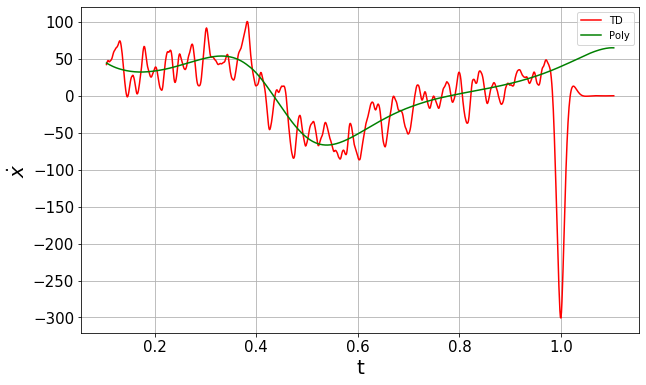

In [124]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[105:subsample+105], xt_T[105:subsample+105], 'r-', label='TD')
plt.plot(t[105:subsample+105], real(xt_P), 'g-', label='Poly')

plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best')

In [225]:
np.random.seed(0)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
q = 1
for i in range(subsample):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
lam = 10**-6
xt_T = TikhonovDiff_modified(xn[:subsample+210], dt, lam, 1)

In [228]:
xt_FD = FiniteDiff(x[105:subsample+105], dt, 1)

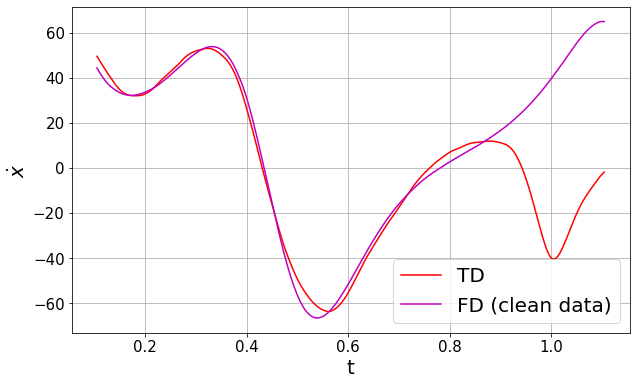

In [231]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(t[105:subsample+105], xt_T[105:subsample+105], 'r-', label='TD')
plt.plot(t[105:subsample+105], xt_FD.real, 'm-', label='FD (clean data)')

plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.savefig('FD_1.pdf')

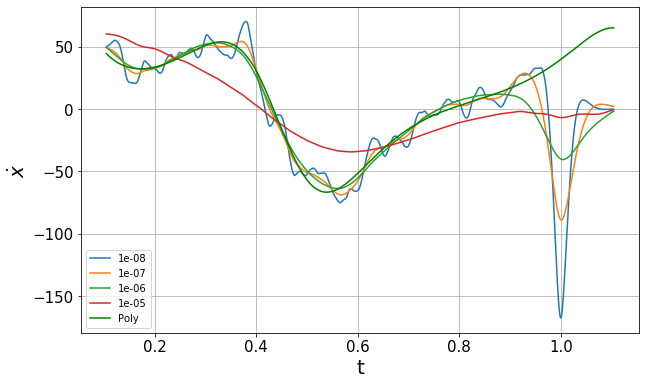

In [125]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
lams = [10**-8, 10**-7, 10**-6, 10**-5]
for lam in lams:
    xt_T = TikhonovDiff_modified(xn[:subsample+210], dt, lam, 1)
    plt.plot(t[105:subsample+105], xt_T[105:subsample+105], label=lam)
plt.plot(t[105:subsample+105], real(xt_P), 'g-', label='Poly')
plt.xlabel('t', fontsize=20)
plt.ylabel(r'$\dot x$',fontsize=20)
plt.legend(loc='best')

In [13]:
numpy.random.seed(0)
noise = [0.0001, 0.001, 0.01, 0.1, 1, 10]
subsample = int(size*0.01)
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
q = 1
for i in range(size):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)

xt_P = np.zeros(subsample)
#xt_FD = np.zeros(subsample)
#xt_T = np.zeros(subsample)

for p in range(subsample):
    j = p + 5
    xt_P[p] = PolyDiffPoint(x_sub[j-((Nt-1)//2):j+((Nt+1)//2)], np.arange(Nt)*dt, deg, 1)[0]

xt_FD = FiniteDiff(xn[105:subsample+105], dt, 1)

lam = 10**-6
xt_T = TikhonovDiff_modified(xn[:subsample+210], dt, lam, 1)

#yt_n = FiniteDiff(yn[:subsample], dt, 1)
#zt_n = FiniteDiff(zn[:subsample], dt, 1)


Xn_data = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_data[105:subsample+105,:], Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

w_xT = SINdy(Theta, xt_T[105:subsample+105].reshape(subsample,1), 2**-3)
w_xFD = SINdy(Theta, xt_FD.reshape(subsample,1), 2**-3)
w_xP = SINdy(Theta, xt_P.reshape(subsample,1), 2**-3)
print_pde(w_xT, description, ut='dxT/dt')
print_pde(w_xFD, description, ut='dxF/dt')
print_pde(w_xP, description, ut='dxP/dt')

dxT/dt = (44.123547 +0.000000i)
    + (-2.708008 +0.000000i)z
    + (5.485160 +0.000000i)y
    + (-2.219286 +0.000000i)x
   
dxF/dt = (17119.005859 +0.000000i)
    + (-2493.475830 +0.000000i)z
    + (-1503.662598 +0.000000i)y
    + (-3682.622070 +0.000000i)x
    + (112.923744 +0.000000i)z^2
    + (49.657642 +0.000000i)yz
    + (-84.448158 +0.000000i)y^2
    + (692.354309 +0.000000i)xz
    + (1133.668457 +0.000000i)xy
    + (-808.064758 +0.000000i)x^2
    + (-1.560749 +0.000000i)z^3
    + (5.554063 +0.000000i)yz^2
    + (13.692845 +0.000000i)y^2z
    + (9.267084 +0.000000i)y^3
    + (-34.396027 +0.000000i)xz^2
    + (-105.082870 +0.000000i)xyz
    + (-67.306252 +0.000000i)xy^2
    + (34.082443 +0.000000i)x^2z
    + (40.064953 +0.000000i)x^2y
    + (41.963440 +0.000000i)x^3
    + (-0.201603 +0.000000i)yz^3
    + (-0.414836 +0.000000i)y^2z^2
    + (-0.497273 +0.000000i)y^3z
    + (-0.295724 +0.000000i)y^4
    + (0.429147 +0.000000i)xz^3
    + (2.065761 +0.000000i)xyz^2
    + (2.518758 +0.

### Various $\lambda$

In [14]:
subsample = 1000
lams = [10**-8, 10**-7, 10**-6, 10**-5]
for lam in lams:
    xt_T = TikhonovDiff_modified(xn[:subsample+210], dt, lam, 1)
    print(lam)
    w_xT = SINdy(Theta, xt_T[105:subsample+105].reshape(subsample,1), 2**-3)
    print_pde(w_xT, description, ut='dxT/dt')

1e-08
dxT/dt = (17.572996 +0.000000i)
    + (-1.216994 +0.000000i)z
    + (-0.318356 +0.000000i)y
    + (8.429639 +0.000000i)x
    + (0.387801 +0.000000i)yz
    + (0.156786 +0.000000i)y^2
    + (-0.652472 +0.000000i)xz
    + (-0.892582 +0.000000i)xy
    + (0.919766 +0.000000i)x^2
   
1e-07
dxT/dt = (13.656052 +0.000000i)
    + (-1.011978 +0.000000i)z
    + (2.063574 +0.000000i)y
    + (6.229467 +0.000000i)x
    + (0.267797 +0.000000i)yz
    + (-0.549238 +0.000000i)xz
    + (-0.488278 +0.000000i)xy
    + (0.689610 +0.000000i)x^2
   
1e-06
dxT/dt = (44.123547 +0.000000i)
    + (-2.708008 +0.000000i)z
    + (5.485160 +0.000000i)y
    + (-2.219286 +0.000000i)x
   
1e-05
dxT/dt = (35.892824 +0.000000i)
    + (-2.594359 +0.000000i)z
    + (4.887757 +0.000000i)y
    + (4.135268 +0.000000i)x
    + (0.267197 +0.000000i)yz
    + (-0.300094 +0.000000i)xz
    + (-1.036692 +0.000000i)xy
    + (0.695224 +0.000000i)x^2
   


In [135]:
xt_T = TikhonovDiff_modified(xn[:subsample+210], dt, 10**-6, 1)
w_xT = SINdy(Theta, xt_T[105:subsample+105].reshape(subsample,1), 0.125)
print_pde(w_xT, description, ut='dxT/dt')

dxT/dt = (-11.763134 +0.000000i)
    + (0.219733 +0.000000i)z
    + (8.272403 +0.000000i)y
    + (-7.706863 +0.000000i)x
   


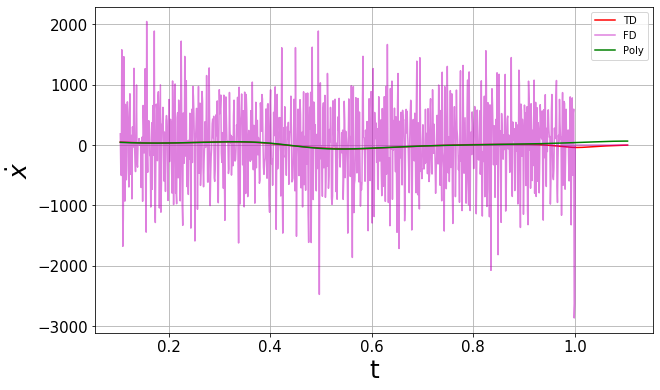

In [136]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.plot(t[105:subsample+105], xt_T[105:subsample+105], 'r-', label='TD')
plt.plot(t[105:subsample+105], xt_FD.real, 'm-', label='FD', alpha=0.5)
plt.plot(t[105:subsample+105], xt_P.real, 'g-', label='Poly')

plt.xlabel('t', fontsize=25)
plt.ylabel(r'$\dot x$', fontsize=25)
plt.legend(loc='best')

Without noise, subsample = 5000 (3 times) and subsample=4000 with noise=1

In [23]:
subsample = 4000
lam = 10**-6
xt_T_1 = TikhonovDiff_modified(xn[:subsample+400], dt, lam, 1)

In [32]:
xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
Theta_1, description = build_Theta(Xn_sub[200:subsample+200,:], Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

In [33]:
w_xn = SINdy(Theta_1, xt_T_1[200:subsample+200].reshape(subsample,1), 2**-3)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.871300 +0.000000i)y
    + (-8.704047 +0.000000i)x
   


In [39]:
yt_T_1 = TikhonovDiff_modified(yn[:subsample+400], dt, lam, 1)
w_yn = SINdy(Theta_1, yt_T_1[200:subsample+200].reshape(subsample,1), 2**-3)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (5.325587 +0.000000i)
    + (0.159153 +0.000000i)z
    + (18.590211 +0.000000i)y
    + (-7.150869 +0.000000i)x
    + (-0.556995 +0.000000i)yz
   


In [45]:
w_yn = SINdy(Theta_1, yt_T_1[200:subsample+200].reshape(subsample,1), 0.4)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (2.950678 +0.000000i)
    + (0.993262 +0.000000i)y
    + (20.210954 +0.000000i)x
    + (-0.808734 +0.000000i)xz
   


In [46]:
zt_T_1 = TikhonovDiff_modified(zn[:subsample+400], dt, lam, 1)
w_zn = SINdy(Theta_1, zt_T_1[200:subsample+200].reshape(subsample,1), 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.479445 +0.000000i)z
    + (0.345449 +0.000000i)y
    + (-0.279590 +0.000000i)x
    + (0.928309 +0.000000i)xy
   


In [28]:
subsample = 1000
lam = 10**-8
xt_T_2 = TikhonovDiff_modified(x[50000:50000+subsample], dt, lam, 1)

Theta_2, description = build_Theta(Xn_sub[50000:50000+subsample,:], Xn_ders_sub, Xn_ders_descr, 5,
                                   data_description = ['x','y','z'])


In [29]:
lam = 10**-8
xt_T_3 = TikhonovDiff_modified(x[90000:90000+subsample], dt, lam, 1)
Theta_3, description = build_Theta(Xn_sub[90000:90000+subsample,:], Xn_ders_sub, Xn_ders_descr, 5,
                                   data_description = ['x','y','z'])

In [31]:
xt_T_1 = TikhonovDiff_modified(x[:subsample], dt, lam, 1)
xt_T_2 = TikhonovDiff_modified(x[50000:50000+subsample], dt, lam, 1)
xt_T_3 = TikhonovDiff_modified(x[90000:90000+subsample], dt, lam, 1)

In [40]:
x1 = xt_T_1[0].reshape(subsample,1)
x2 = xt_T_2[0].reshape(subsample,1)
x3 = xt_T_3[0].reshape(subsample,1)
Big_Theta = np.vstack([Theta,Theta_2,Theta_3])
dot_X = np.vstack([x1,x2,x3])

In [48]:
Big_Theta.shape

(15000, 56)

In [43]:
W_xn = SINdy(Big_Theta, dot_X, 2**-3)
print_pde(W_xn, description, ut='dx/dt')

dx/dt = (9.996698 +0.000000i)y
    + (-9.997318 +0.000000i)x
   


In [44]:
yt_T_2 = TikhonovDiff_modified(y[50000:50000+subsample], dt, lam, 1)
yt_T_3 = TikhonovDiff_modified(y[90000:90000+subsample], dt, lam, 1)

In [46]:
y1 = yt_T_1[0].reshape(subsample,1)
y2 = yt_T_2[0].reshape(subsample,1)
y3 = yt_T_3[0].reshape(subsample,1)
dot_Y = np.vstack([y1,y2,y3])

In [47]:
W_yn = SINdy(Big_Theta, dot_Y, 2**-3)
print_pde(W_yn, description, ut='dy/dt')

dy/dt = (-0.965316 +0.000000i)y
    + (27.872154 +0.000000i)x
    + (-0.996207 +0.000000i)xz
   


### subsample=1000 (10 times)

In [13]:
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)

In [14]:
subsample = int(0.01*size)
lam = 10**-6
Xt_1 = np.zeros((subsample+400, 10))
q = 1
for i in range(size):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
theta_1 = np.zeros((subsample, 10*56))

for i in range(10):
    #part = np.random.choice(10,1)[0]
    index = i*10000 
   #print(index)
    Xt_1[:, i] = TikhonovDiff_modified(xn[index:index+subsample+400], dt, lam, 1)
    theta_1[:, 56*i:56*(i+1)], description = build_Theta(Xn_sub[index+200:index+subsample+200,:],
                                             Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


In [16]:
Theta_1 = theta_1[:, :56]
dot_x_1 = Xt_1[200:subsample+200,0].reshape(1000,1)
for i in range(1, 10):
    Theta_1 = np.vstack([Theta_1, theta_1[:,56*i:56*(i+1)]])
    col = Xt_1[200:subsample+200,i].reshape(1000, 1)
    dot_x_1 = np.vstack([dot_x_1, col])

It's better! (again launch) 

In [22]:
w_xn = SINdy(Theta_1, dot_x_1, 0.5)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.769443 +0.000000i)y
    + (-8.658542 +0.000000i)x
   


In [23]:
l0_penalty = 0.001*np.linalg.cond(theta)

In [24]:
l0_penalty

7911144.934858305

In [27]:
np.linalg.norm(dot_x - theta.dot(w_xn), 2)

1330.7794784937983

In [24]:
Yt_1 = np.zeros((subsample+400, 10))
for i in range(10):
    #part = np.random.choice(10,1)[0]
    index = i*10000 
    #print(index)
    Yt_1[:, i] = TikhonovDiff_modified(yn[index:index+subsample+400], dt, lam, 1)

In [25]:
dot_y_1 = Yt_1[200:subsample+200,0].reshape(1000,1)
for i in range(1, 10):
    col = Yt_1[200:subsample+200,i].reshape(1000, 1)
    dot_y_1 = np.vstack([dot_y_1, col])

In [44]:
w_yn = SINdy(Theta_1, dot_y_1, 0.5)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.927469 +0.000000i)
    + (0.695146 +0.000000i)y
    + (20.979482 +0.000000i)x
    + (-0.818060 +0.000000i)xz
   


In [46]:
w_yn = SINdy(Theta_1, dot_y_1, 0.7)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.782333 +0.000000i)
    + (22.607833 +0.000000i)x
    + (-0.849941 +0.000000i)xz
   


In [47]:
Zt_1 = np.zeros((subsample+400, 10))
for i in range(10):
    #part = np.random.choice(10,1)[0]
    index = i*10000 
    Zt_1[:, i] = TikhonovDiff_modified(zn[index:index+subsample+400], dt, lam, 1)

In [48]:
dot_z_1 = Zt_1[200:subsample+200,0].reshape(1000,1)
for i in range(1, 10):
    col = Zt_1[200:subsample+200,i].reshape(1000, 1)
    dot_z_1 = np.vstack([dot_z_1, col])

In [50]:
w_zn = SINdy(Theta_1, dot_z_1, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-0.805842 +0.000000i)
    + (-2.447845 +0.000000i)z
    + (0.920512 +0.000000i)xy
   


Сontinuously

In [92]:
subsample = int(0.01*size)
lam = 10**-6
Xt1 = np.zeros((subsample+400, 10))

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
theta1 = np.zeros((subsample, 10*56))

for i in range(10):
    #part = np.random.choice(10,1)[0]
    index = i*1000 
   #print(index)
    Xt1[:, i] = TikhonovDiff_modified(xn[index:index+subsample+400], dt, lam, 1)
    theta1[:, 56*i:56*(i+1)], description = build_Theta(Xn_sub[index+200:index+subsample+200,:],
                                             Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


In [94]:
Theta1 = theta1[:, :56]
dot_x1 = Xt1[200:subsample+200,0].reshape(1000,1)
for i in range(1, 10):
    Theta1 = np.vstack([Theta1, theta1[:,56*i:56*(i+1)]])
    col = Xt1[200:subsample+200,i].reshape(1000, 1)
    dot_x1 = np.vstack([dot_x1, col])

In [95]:
w_xn = SINdy(Theta1, dot_x1, 0.5)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.807136 +0.000000i)y
    + (-8.671835 +0.000000i)x
   


In [96]:
Yt1 = np.zeros((subsample+400, 10))
for i in range(10):
    #part = np.random.choice(10,1)[0]
    index = i*1000 
    #print(index)
    Yt1[:, i] = TikhonovDiff_modified(yn[index:index+subsample+400], dt, lam, 1)

In [97]:
dot_y1 = Yt1[200:subsample+200,0].reshape(1000,1)
for i in range(1, 10):
    col = Yt1[200:subsample+200,i].reshape(1000, 1)
    dot_y1 = np.vstack([dot_y1, col])

In [100]:
w_yn = SINdy(Theta1, dot_y1, 0.5)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.942449 +0.000000i)
    + (0.735297 +0.000000i)y
    + (20.797789 +0.000000i)x
    + (-0.818771 +0.000000i)xz
   


In [113]:
w_yn = SINdy(Theta1, dot_y1, 0.1)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (5.180509 +0.000000i)y
    + (15.062386 +0.000000i)x
    + (-0.151278 +0.000000i)yz
    + (-0.641386 +0.000000i)xz
   


In [116]:
w_yn = SINdy(Theta1, dot_y1, 0.35)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.942449 +0.000000i)
    + (0.735297 +0.000000i)y
    + (20.797789 +0.000000i)x
    + (-0.818771 +0.000000i)xz
   


### subsample = 1000 (20 times)

In [222]:
subsample = int(0.01*size)
lam = 10**-6
Xt = np.zeros((subsample, 20))
q = 1 
for i in range(size):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)

Xt = np.zeros((subsample+400, 20))
Theta = np.zeros((subsample, 20*56))

Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
Theta = np.zeros((subsample, 20*56))

for i in range(20):
    #part = np.random.choice(5,1)[0]
    index = i*5000
    #print(index)
    Xt[:, i] = TikhonovDiff_modified(xn[index:index+subsample+400], dt, lam, 1)
    Theta[:, 56*i:56*(i+1)], _ = build_Theta(Xn_sub[index+200:index+subsample+200,:],
                                             Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [223]:
theta = Theta[:, :56]
dot_x = Xt[200:subsample+200,0].reshape(1000,1)
for i in range(1, 20):
    theta = np.vstack([theta, Theta[:,56*i:56*(i+1)]])
    col = Xt[200:subsample+200,i].reshape(1000, 1)
    dot_x = np.vstack([dot_x, col])

In [224]:
w_xn = SINdy(theta, dot_x, 1)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.760215 +0.000000i)y
    + (-8.635670 +0.000000i)x
   


In [225]:
Yt = np.zeros((subsample+400, 20))
for i in range(20):
    #part = np.random.choice(5,1)[0]
    index = i*5000
    #print(index)
    Yt[:, i] = TikhonovDiff_modified(yn[index:index+subsample+400], dt, lam, 1)

In [227]:
dot_y = Yt[200:subsample+200,0].reshape(1000,1)
for i in range(1, 20):
    col = Yt[200:subsample+200,i].reshape(1000, 1)
    dot_y = np.vstack([dot_y, col])

In [233]:
w_yn = SINdy(theta, dot_y, 0.3)
print_pde(w_yn, description, ut='dyT/dt')

dyT/dt = (0.670856 +0.000000i)y
    + (20.964792 +0.000000i)x
    + (-0.817630 +0.000000i)xz
   


In [234]:
Zt = np.zeros((subsample+400, 20))
for i in range(20):
    #part = np.random.choice(5,1)[0]
    index = i*5000
    #print(index)
    Zt[:, i] = TikhonovDiff_modified(zn[index:index+subsample+400], dt, lam, 1)

In [235]:
dot_z = Zt[200:subsample+200,0].reshape(1000,1)
for i in range(1, 20):
    col = Zt[200:subsample+200,i].reshape(1000, 1)
    dot_z = np.vstack([dot_z, col])

In [238]:
w_zn = SINdy(theta, dot_z, 0.5)
print_pde(w_zn, description, ut='dzT/dt')

dzT/dt = (-1.838393 +0.000000i)
    + (-2.417348 +0.000000i)z
    + (0.927663 +0.000000i)xy
   


### subsample =1000 (50 times)

In [21]:
subsample = int(0.01*size)
lam = 10**-6
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
q = 1
for i in range(size):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

xn = xn.reshape(size, 1)
yn = yn.reshape(size, 1)
zn = zn.reshape(size, 1)

Xt = np.zeros((50*subsample, 1))
Theta = np.zeros((50*subsample, 56))

for i in range(50):
    #part = np.random.choice(2,1)[0]
    index = i*2000
    #print(index)
    Xt[i*subsample:(i+1)subsample, :] = TikhonovDiff_modified(x[index:index+subsample], dt, lam, 1)
    Theta[i*subsample:(i+1)subsample, :], description = build_Theta(Xn_sub[index:index+subsample,:],
                                             Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


In [22]:
theta = Theta[:, :56]
dot_x = Xt[:,0].reshape(1000,1)
for i in range(1, 50):
    theta = np.vstack([theta, Theta[:,56*i:56*(i+1)]])
    col = Xt[:,i].reshape(1000, 1)
    dot_x = np.vstack([dot_x, col])

In [23]:
w_xn = SINdy(Theta, dot_x, 2**-3)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (-0.690035 +0.000000i)
    + (8.479838 +0.000000i)y
    + (-8.374024 +0.000000i)x
   


In [25]:
w_xn = SINdy(theta, dot_x, 1)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (8.483013 +0.000000i)y
    + (-8.392627 +0.000000i)x
   


In [26]:
Yt = np.zeros((subsample, 50))
for i in range(50):
    #part = np.random.choice(2,1)[0]
    index = i*2000
    #print(index)
    Yt[:, i] = TikhonovDiff_modified(y[index:index+subsample], dt, lam, 1)

In [27]:
dot_y = Yt[:,0].reshape(1000,1)
for i in range(1, 50):
    col = Yt[:,i].reshape(1000, 1)
    dot_y = np.vstack([dot_y, col])

In [33]:
w_yn = SINdy(theta, dot_y, 0.2)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (1.030092 +0.000000i)y
    + (18.942624 +0.000000i)x
    + (-0.759808 +0.000000i)xz
   


In [122]:
subsample = 1000
Zt = np.zeros((subsample, 50))
for i in range(50):
    part = np.random.choice(2,1)[0]
    index = i*2000 + part*1000
    #print(index)
    Zt[:, i] = TikhonovDiff_modified(z[index:index+subsample], dt, lam, 1)

In [123]:
dot_z = Zt[:,0].reshape(1000,1)
for i in range(1, 50):
    col = Zt[:,i].reshape(1000, 1)
    dot_z = np.vstack([dot_z, col])

In [124]:
w_zn = SINdy(theta, dot_z, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-5.317822 +0.000000i)
    + (0.172099 +0.000000i)z
    + (0.149958 +0.000000i)x
   


Try TrainSTRidge :(

In [127]:
w_x = TrainSTRidge(theta, dot_x, 10**-5, 2**-3,normalize = 0)
print_pde(w_x, description, ut='dx/dt')
w_y = TrainSTRidge(theta, dot_y, 10**-5, 2**-3,normalize = 0)
print_pde(w_y, description, ut='dy/dt')
w_z = TrainSTRidge(theta, dot_z, 10**-5, 2**-3,normalize = 0)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (0.000967 +0.000000i)yz^2
   
dy/dt = (-0.001847 +0.000000i)z^2
   
dz/dt = (0.003817 +0.000000i)y^2z
    + (-0.004437 +0.000000i)xyz
    + (0.001239 +0.000000i)x^2z
    + (0.000469 +0.000000i)x^3
   


### subsample=1000 (100 times)

In [232]:
xn = np.zeros(size)
yn = np.zeros(size)
zn = np.zeros(size)
q = 1
for i in range(size):
    xn[i] = x[i] + q*np.random.randn()
    yn[i] = y[i] + q*np.random.randn()
    zn[i] = z[i] + q*np.random.randn()

In [233]:
subsample = int(0.01*size)
lam = 10**-6
Xt = np.zeros((subsample, 100))
xn = x.reshape(size, 1)
yn = y.reshape(size, 1)
zn = z.reshape(size, 1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']
Theta = np.zeros((subsample, 100*56))

for i in range(100):
    index = i*1000
    #print(index)
    Xt[:, i] = TikhonovDiff_modified(x[index:index+subsample], dt, lam, 1)
    Theta[:, 56*i:56*(i+1)], _ = build_Theta(Xn_sub[index:index+subsample,:],
                                             Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [234]:
theta = Theta[:, :56]
dot_x = Xt[:,0].reshape(1000,1)
for i in range(1, 100):
    theta = np.vstack([theta, Theta[:,56*i:56*(i+1)]])
    col = Xt[:,i].reshape(1000, 1)
    dot_x = np.vstack([dot_x, col])

In [235]:
w_xn = SINdy(theta, dot_x, 0.5)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (9.365229 +0.000000i)y
    + (-9.395838 +0.000000i)x
   


In [240]:
Yt = np.zeros((subsample, 100))
for i in range(100):
    index = i*1000
    #print(index)
    Yt[:, i] = TikhonovDiff_modified(y[index:index+subsample], dt, lam, 1)

In [23]:
dot_y = Yt[:,0].reshape(1000,1)
for i in range(1, 100):
    col = Yt[:,i].reshape(1000, 1)
    dot_y = np.vstack([dot_y, col])

In [25]:
w_yn = SINdy(theta, dot_y, 2**-3)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (0.502066 +0.000000i)y
    + (20.928785 +0.000000i)x
    + (-0.808226 +0.000000i)xz
   


In [236]:
Zt = np.zeros((subsample, 100))
for i in range(100):
    index = i*1000
    #print(index)
    Zt[:, i] = TikhonovDiff_modified(z[index:index+subsample], dt, lam, 1)

In [237]:
dot_z = Zt[:,0].reshape(1000,1)
for i in range(1, 100):
    col = Zt[:,i].reshape(1000, 1)
    dot_z = np.vstack([dot_z, col])

In [238]:
w_zn = SINdy(theta, dot_z, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (15.196902 +0.000000i)
    + (-3.422943 +0.000000i)z
    + (-0.131879 +0.000000i)y
    + (0.219775 +0.000000i)x
    + (0.193826 +0.000000i)y^2
    + (0.391982 +0.000000i)xy
    + (0.395236 +0.000000i)x^2
   


In [239]:
w_zn = SINdy(theta, dot_z, 0.5)
print_pde(w_zn, description, ut='dz/dt')

dz/dt = (-2.432630 +0.000000i)z
    + (0.908662 +0.000000i)xy
   


TrainSTRidge (with normalization it's even worse)

In [42]:
w_x = TrainSTRidge(theta, dot_x, 10**-5, 2**-3,normalize = 0)
print_pde(w_x, description, ut='dx/dt')
w_y = TrainSTRidge(theta, dot_y, 10**-5, 2**-3,normalize = 0)
print_pde(w_y, description, ut='dy/dt')
w_z = TrainSTRidge(theta, dot_z, 10**-5, 2**-3,normalize = 0)
print_pde(w_z, description, ut='dz/dt')

dx/dt = (0.000894 +0.000000i)yz^2
   
dy/dt = (-0.003753 +0.000000i)yz^2
   
dz/dt = (0.000019 +0.000000i)z^2
   


If treshold is from $10^{-3}$ to $10^{-1}$, no difference

In [96]:
w_xn = SINdy(theta, dot_x, 10**-1)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (9.996768 +0.000000i)y
    + (-9.996690 +0.000000i)x
   


In [134]:
w_yn = SINdy(theta, dot_y, 2**-3)
print_pde(w_yn, description, ut='dy/dt')

dy/dt = (2.752247 +0.000000i)
    + (20.750015 +0.000000i)y
    + (-7.103178 +0.000000i)x
    + (-0.620746 +0.000000i)yz
   


subsample = 5000 for lam = $10^{-5}$

In [26]:
w_xn = SINdy(Theta, xt_T[0].reshape(subsample,1), 2**-3)
print_pde(w_xn, description, ut='dx/dt')

dx/dt = (1.066781 +0.000000i)
    + (16.474550 +0.000000i)y
    + (-19.449949 +0.000000i)x
    + (-0.269314 +0.000000i)yz
    + (0.334575 +0.000000i)xz
   


subsample = 2000 for lam = $10^{-5}$

In [44]:
xn = xn.reshape(size,1)
yn = yn.reshape(size,1)
zn = zn.reshape(size,1)
Xn_sub = np.hstack([xn,yn,zn])
Xn_ders_sub = np.ones((subsample,1))
Xn_ders_descr = ['']

Theta, description = build_Theta(Xn_sub[:subsample,:], Xn_ders_sub, Xn_ders_descr, 5, data_description = ['x','y','z'])

w_xn = SINdy(Theta, xt_T, 2**-3)
print_pde(w_xn, description, ut='dx/dt')
w_yn = SINdy(Theta, yt_T, 2**-3)
print_pde(w_yn, description, ut='dy/dt')
w_zn = SINdy(Theta, zt_T, 2**-3)
print_pde(w_zn, description, ut='dz/dt')

dx/dt = (1.160922 +0.000000i)
    + (17.206408 +0.000000i)y
    + (-20.963167 +0.000000i)x
    + (-0.280724 +0.000000i)yz
    + (0.370510 +0.000000i)xz
   
dy/dt = (0.776054 +0.000000i)
    + (1.937740 +0.000000i)y
    + (12.623181 +0.000000i)x
    + (-0.572100 +0.000000i)xz
   
dz/dt = (46.936265 +0.000000i)
    + (-5.255209 +0.000000i)z
    + (-0.234270 +0.000000i)y
    + (0.654034 +0.000000i)x
    + (0.518999 +0.000000i)y^2
    + (-0.642182 +0.000000i)xy
    + (1.148268 +0.000000i)x^2
   
